In [556]:
%load_ext autoreload
%autoreload

## Setup

In [1]:
import os, sys, warnings, json, glob, tables
from pathlib import Path
path = str(Path(os.path.join('..','src','elohim','elohim')).resolve())
if path not in sys.path:
    sys.path.insert(0,path)

## Loading lastly recorded simulation instance

In [2]:
import os, json, glob, re
import numpy as np
ds = [d for d in sorted(os.scandir(os.path.join('..','history')), key=lambda x:x.path, reverse=False) if re.match(r'(.*?)[0-9]{4}-[0-9]{6}', d.path) is not None]
print([d.path for d in ds])
d = ds[-1]
print(f'The most recent simulation folder has been selected "{d.path}":')
points_file = os.path.join(d.path, 'points.json')
assert os.path.exists(points_file)
with open(points_file) as f:
    points = json.load(f)
targets = np.array([[t["x"], t["y"]] for t in points["targets"]])
fp_files = glob.glob(f'{d.path}/*.h5')
files = [os.path.basename(x) for x in fp_files]
files

['../history/1231-000050', '../history/1231-001235', '../history/1231-001724', '../history/1231-002801']
The most recent simulation folder has been selected "../history/1231-002801":


['virtual_sensor_center.h5',
 'head_camera_image_raw.h5',
 'virtual_sensor_left.h5',
 'odom.h5',
 'virtual_sensor_right.h5',
 'virtual_sensor_center_left.h5',
 'ground_truth_odom.h5',
 'run_counter.h5',
 'virtual_sensor_center_right.h5']

What are the obstacles coordinates in this specific simulation instance?

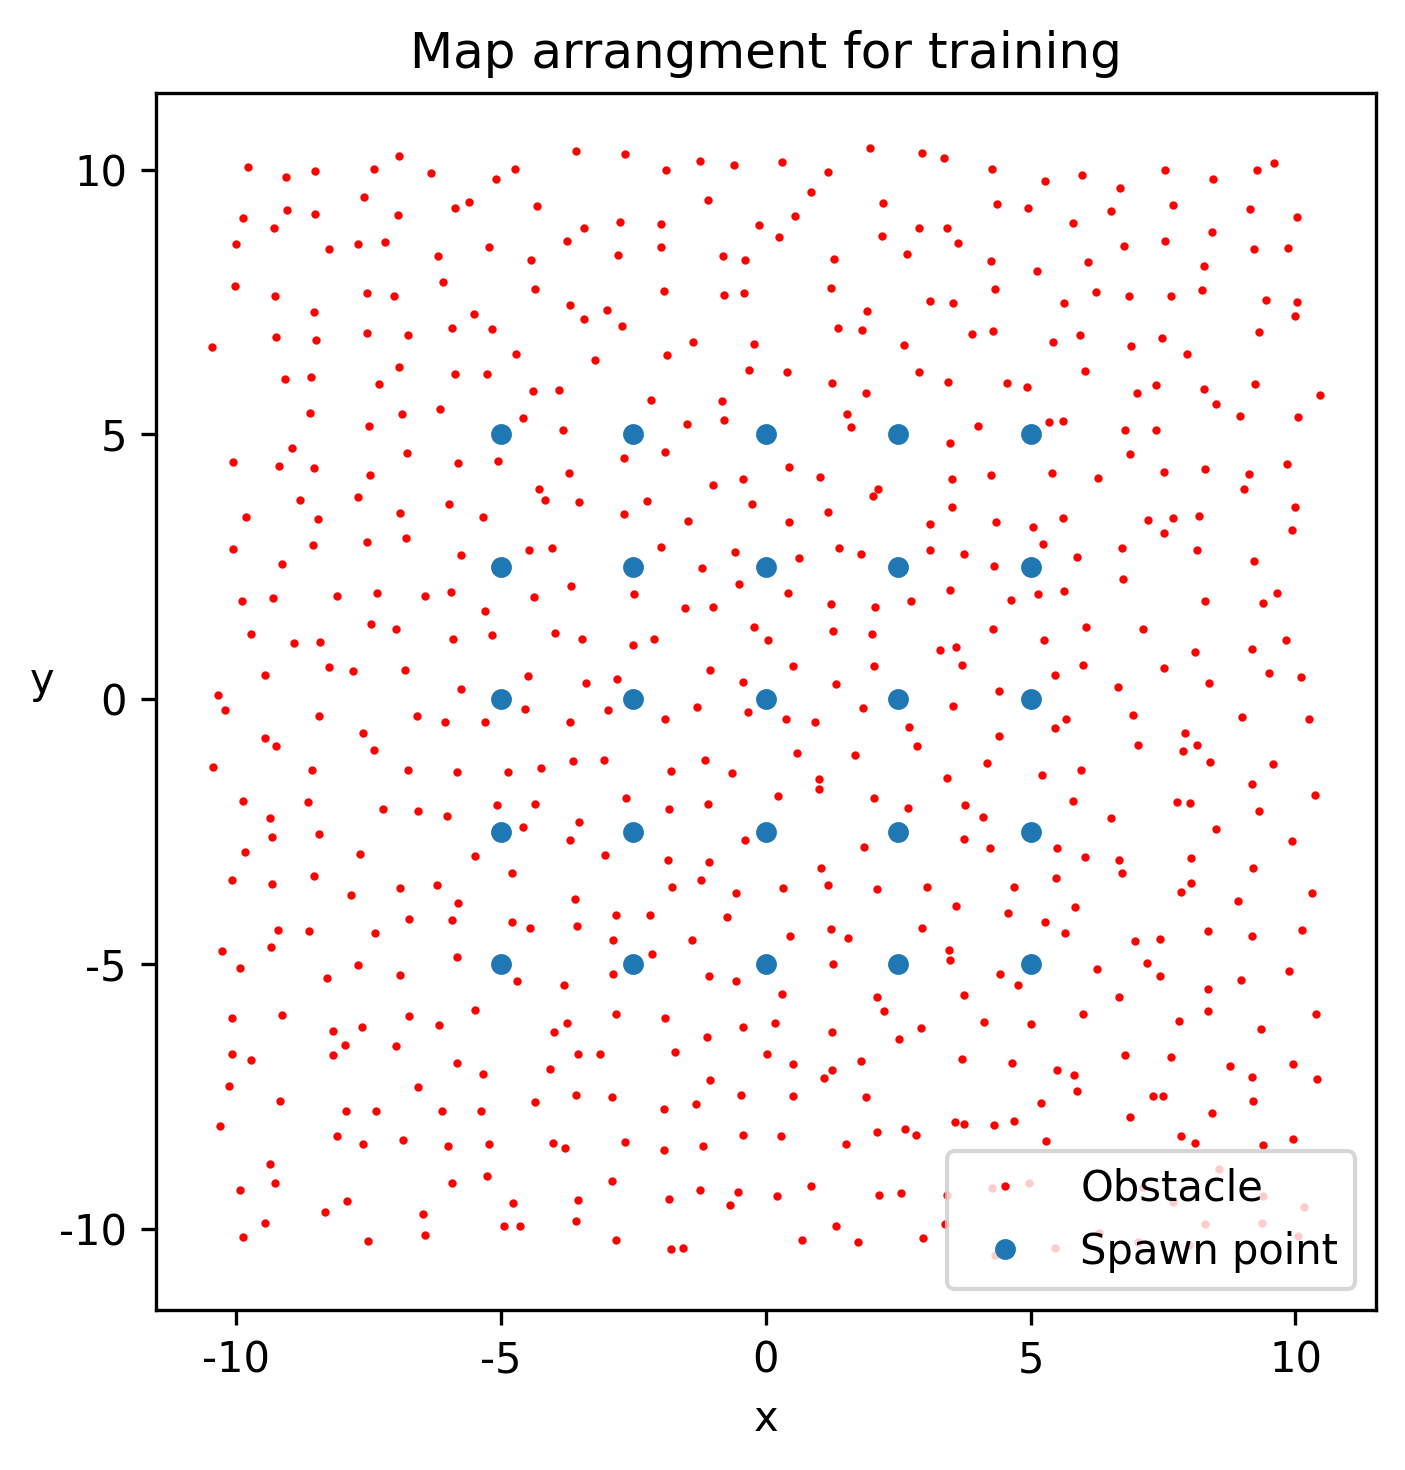

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
points_file = os.path.join(d.path, 'points.json')
with open(points_file) as f:
    points_d = json.load(f)
targets = np.array([[t["x"], t["y"]] for t in points_d["targets"]])
spawn_coords = np.array([[t["x"], t["y"]] for t in points_d["spawn_coords"]])
fig, ax = plt.subplots(figsize=(5,5),dpi=300)
ax.plot(*targets.T, 'o', c='red',ms=1, label='Obstacle')
ax.plot(*spawn_coords.T, 'o', ms=4, label='Spawn point')
ax.set_xlabel('x')
ax.set_ylabel('y',rotation=0)
ax.set_aspect('equal')
ax.legend()
ax.set_title('Map arrangment for training')
plt.tight_layout()
plt.savefig('training_map_1.png')
plt.show()

Let's move everything from hdf5 to pandas, while taking the necessary precaution in case the custom rosbag was still appending data

In [12]:
import warnings, time
import pandas as pd, tables

assert len(files) >= 4
print('Preparing dataset..', end=' ')
last_snapshot = {}
while len(last_snapshot) == 0:
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=tables.PerformanceWarning)
            last_snapshot = {}
            for ff in fp_files:
                last_snapshot[ff] = pd.read_hdf(ff)
                print(last_snapshot[ff].columns)
    except ValueError:
        print(f'No dataset in HDF5 file: {ff}')
        exit()
    except Exception:
        print("Recorder is probably locking the file, trying again in 3 second")
        time.sleep(3)
print('Done')
display(pd.concat([last_snapshot[i].head(1).reset_index(drop=True) for i in fp_files], axis=1))


Preparing dataset.. Index(['center'], dtype='object')
Index(['image'], dtype='object')
Index(['left'], dtype='object')
Index(['x', 'y', 'theta'], dtype='object')
Index(['right'], dtype='object')
Index(['center_left'], dtype='object')
Index(['x', 'y', 'theta'], dtype='object')
Index(['run'], dtype='object')
Index(['center_right'], dtype='object')
Done


,center,image,left,x,y,theta,right,center_left,x,y,theta,run,center_right
0,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,0.014714,-0.000027,-0.004411,0.12,0.12,0.008432,2.502534,0.302995,1,0.12


### Let's merge dataframes of data from different sensors

In [13]:
import analyzer, importlib
from analyzer import mergedfs
importlib.reload(analyzer)
df = mergedfs(last_snapshot)
print(f'Unique runs: {len(df["run"].unique())}')
df

virtual_sensor_center.h5        242178


/usr/local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


head_camera_image_raw.h5        247933
virtual_sensor_left.h5          242235
odom.h5                         245386
virtual_sensor_right.h5         241657
virtual_sensor_center_left.h5   242260
{'x', 'y', 'theta'} {'center_left', 'left', 'x', 'right', 'image', 'y', 'theta', 'center'}
ground_truth_odom.h5            244968
run_counter.h5                  328505
virtual_sensor_center_right.h5  241710
Resulting length: 241651. Total discarded records: -6.1% (-139678/2276832).
Unique runs: 785


,right,center,image,left,x,y,theta,center_left,ground_truth_odom_x,ground_truth_odom_y,ground_truth_odom_theta,run,center_right
time,,,,,,,,,,,,,
2020-12-30 23:29:10.955594480,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,0.110986,0.006568,0.131573,0.12,0.093322,2.533403,0.403457,1,0.12
2020-12-30 23:29:11.068177193,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,0.125664,0.008786,0.168460,0.12,0.106876,2.539443,0.435221,1,0.12
2020-12-30 23:29:11.177343918,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,0.140249,0.011545,0.205371,0.12,0.120231,2.545911,0.467008,1,0.12
2020-12-30 23:29:11.289828707,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,0.154722,0.014840,0.242310,0.12,0.133372,2.552800,0.498820,1,0.12
2020-12-30 23:29:11.399981657,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,0.169063,0.018667,0.279278,0.12,0.146287,2.560103,0.530659,1,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 08:37:01.782988925,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,54.940256,-30.869734,0.503986,0.12,-1.527749,-4.548048,-2.159020,784,0.12
2020-12-31 08:37:01.910286133,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,54.940238,-30.869744,0.474986,0.12,-1.527740,-4.548038,-2.183875,784,0.12
2020-12-31 08:37:02.046762555,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,54.940227,-30.869750,0.445977,0.12,-1.527731,-4.548028,-2.208834,784,0.12


### Before starting to process data, we need a quick tool to visually check any particular simulation run that shows odd statistics

In particular, let's use the camera feed, imshow funcanim should be quick enough

In [14]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from fractions import Fraction
import pathlib
from IPython.display import Video
import config
import sys
from pathlib import Path

from utils import cv_from_binary

def show_camera_feed(df, target='run', run_id=None, big_run_id=None, folder=None, rate=30, s=None):

    if run_id is not None:
        data = df[df['run'] == run_id][['image',target]].copy()
    if big_run_id is not None:
        data = df[df['big_block'] == big_run_id][['image',target]].copy()
    else:
        data = df[['image',target]].copy()
        
    if s is not None:
        data = data.iloc[s]
    
    if len(data) == 0:
        print('empty')
        return
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=rate, metadata=dict(artist='Me'), bitrate=1800)
    images = data['image'].map(cv_from_binary).map(Image.fromarray, "RGB").values
    
    matplotlib.rcParams['animation.embed_limit'] = images.nbytes * 13215
    frac = Fraction(*config.camera_shape[:2][::-1])
    fig, ax = plt.subplots(figsize=(frac.numerator*2,frac.denominator*2))
    ax.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    feed_frame = ax.imshow(images[0])
    
    sensor_data = data[target].round(3).astype(str).values
    sensor = ax.text(0.1,0.1, s=sensor_data[0], weight='bold', color='white', size=25, transform=ax.transAxes)
    def init():
        feed_frame.set_data(images[0])
        sensor.set_text(sensor_data[0])
        return feed_frame, sensor,
    def animate(i):
        feed_frame.set_data(images[i])
        sensor.set_text(sensor_data[i])
        return feed_frame, sensor,
    ani = FuncAnimation(fig, animate, frames=len(images), interval=1000. / rate, blit=True, init_func=init, repeat=True)
    plt.close()
    
    if folder is None:
        folder = '.'
    folder = os.path.join(folder, 'single_runs')
    pathlib.Path(folder).mkdir(parents=True, exist_ok=True)
    file_path = os.path.join(folder,f'run_{str(run_id).zfill(3)}.mp4')
    ani.save(file_path, writer=writer, progress_callback=lambda i, n: print(f'\rProgress: {(i+1) * 100. / n:.2f} %', end=''))
    print(f'\rComplete! Video file saved to {file_path}')
    return Video(file_path)

In [7]:
size = 500
a = np.random.randint(len(df)-size)
show_camera_feed(df.iloc[a:a+size])

Complete! Video file saved to ./single_runs/run_None.mp4


In [15]:
def extract_big_runs(df):
    df = df.copy()
    out_of_map = (df[['ground_truth_odom_x','ground_truth_odom_y']].abs() > 10).any(axis=1)
    df['big_block'] = (out_of_map != out_of_map.shift(1)).cumsum().astype(int)
    df = df[~out_of_map]
    df['big_block'] = (df['big_block'] != df['big_block'].shift(1)).cumsum().astype(int)
    #df.groupby('big_block').apply(lambda x: display(x))
    print(df['big_block'].unique())
    return df
df = extract_big_runs(df)
df

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]


,right,center,image,left,x,y,theta,center_left,ground_truth_odom_x,ground_truth_odom_y,ground_truth_odom_theta,run,center_right,big_block
time,,,,,,,,,,,,,,
2020-12-30 23:29:10.955594480,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,0.110986,0.006568,0.131573,0.12,0.093322,2.533403,0.403457,1,0.12,1
2020-12-30 23:29:11.068177193,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,0.125664,0.008786,0.168460,0.12,0.106876,2.539443,0.435221,1,0.12,1
2020-12-30 23:29:11.177343918,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,0.140249,0.011545,0.205371,0.12,0.120231,2.545911,0.467008,1,0.12,1
2020-12-30 23:29:11.289828707,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,0.154722,0.014840,0.242310,0.12,0.133372,2.552800,0.498820,1,0.12,1
2020-12-30 23:29:11.399981657,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,0.169063,0.018667,0.279278,0.12,0.146287,2.560103,0.530659,1,0.12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 08:37:01.782988925,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,54.940256,-30.869734,0.503986,0.12,-1.527749,-4.548048,-2.159020,784,0.12,30
2020-12-31 08:37:01.910286133,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,54.940238,-30.869744,0.474986,0.12,-1.527740,-4.548038,-2.183875,784,0.12,30
2020-12-31 08:37:02.046762555,0.12,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,54.940227,-30.869750,0.445977,0.12,-1.527731,-4.548028,-2.208834,784,0.12,30


Maybe let's remove the -1 save iterations

In [16]:
(df['run'] == -1).value_counts()

False    241209
True         54
Name: run, dtype: int64

In [38]:
#show_camera_feed(df, big_run_id=1)

# Analysis

In [ ]:
# import config
# df['obstacle_near'] = df['sensor'] != config.max_sensor_threshold
# display(df['sensor'].min())
# df

Let's remove all runs that are too short to even build a single occupancy map

In [ ]:
# import config

# window = '20s'
# df = df.groupby('run').filter(lambda x: (x.index[-1]-x.index[0]) > pd.Timedelta(window))
# df = df[df['run'] != -1]

Let's label 'out of map' runs

In [ ]:
# df = df.groupby("run").apply(lambda x: x.assign(out_of_map=
#             True if (x[[f"ground_truth_odom_{a}" for a in ["x","y"]]].iloc[-1].abs() > config.plane_side/2).any()
#             else False)).reset_index(level=0, drop=True)

Let's check that we are correctly labeling run that end with 'out of map' scenarios

In [ ]:
# def statistics(df):
#     print(f'Unique runs: {len(df["run"].unique())}')
#     print(f'Out of map runs: {len(df.groupby("run").filter(lambda x: x["out_of_map"].any())["run"].unique())*100/len(df["run"].unique()):2.0f}%')
#     s0, s1, s2 = df["obstacle_near"], df.loc[df["out_of_map"],"obstacle_near"], df.loc[~df["out_of_map"],"obstacle_near"]
#     perc = lambda x: x.astype(int).sum()*100/len(df)
#     print(f'Obstacle detection readings - Total: {perc(s0):2.1f}%,\nOut Of Map scenarios total obstacle readings: {perc(s1):2.1f}%,\nObstacle scenarios total: {perc(s2):2.1f}%')
#     print(f'Average % of obs. detection readings per run: {df[~df["out_of_map"]].groupby("run")["obstacle_near"].apply(lambda x: x.sum()/len(x)).mean()*100:2.2f}%')  
# statistics(df)

In [17]:
import seaborn as sns
def setup_topview(ax, fixed=True):
    half_side = config.plane_side // 2
    bounds = [-half_side - 1, half_side + 1]
    if fixed:
        ax.set(xlim=bounds, ylim=bounds, autoscale_on=False)
        major_ticks = np.arange(-half_side, half_side + 1, 5)
        minor_ticks = np.arange(-half_side, half_side + 1, 2.5)
        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        ax.set_yticks(major_ticks)
        ax.set_yticks(minor_ticks, minor=True)
    ax.set(title="Top view", adjustable='box')
   
    ax.grid(which='both')
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)

100%|██████████| 6/6 [00:00<00:00, 33.23it/s]


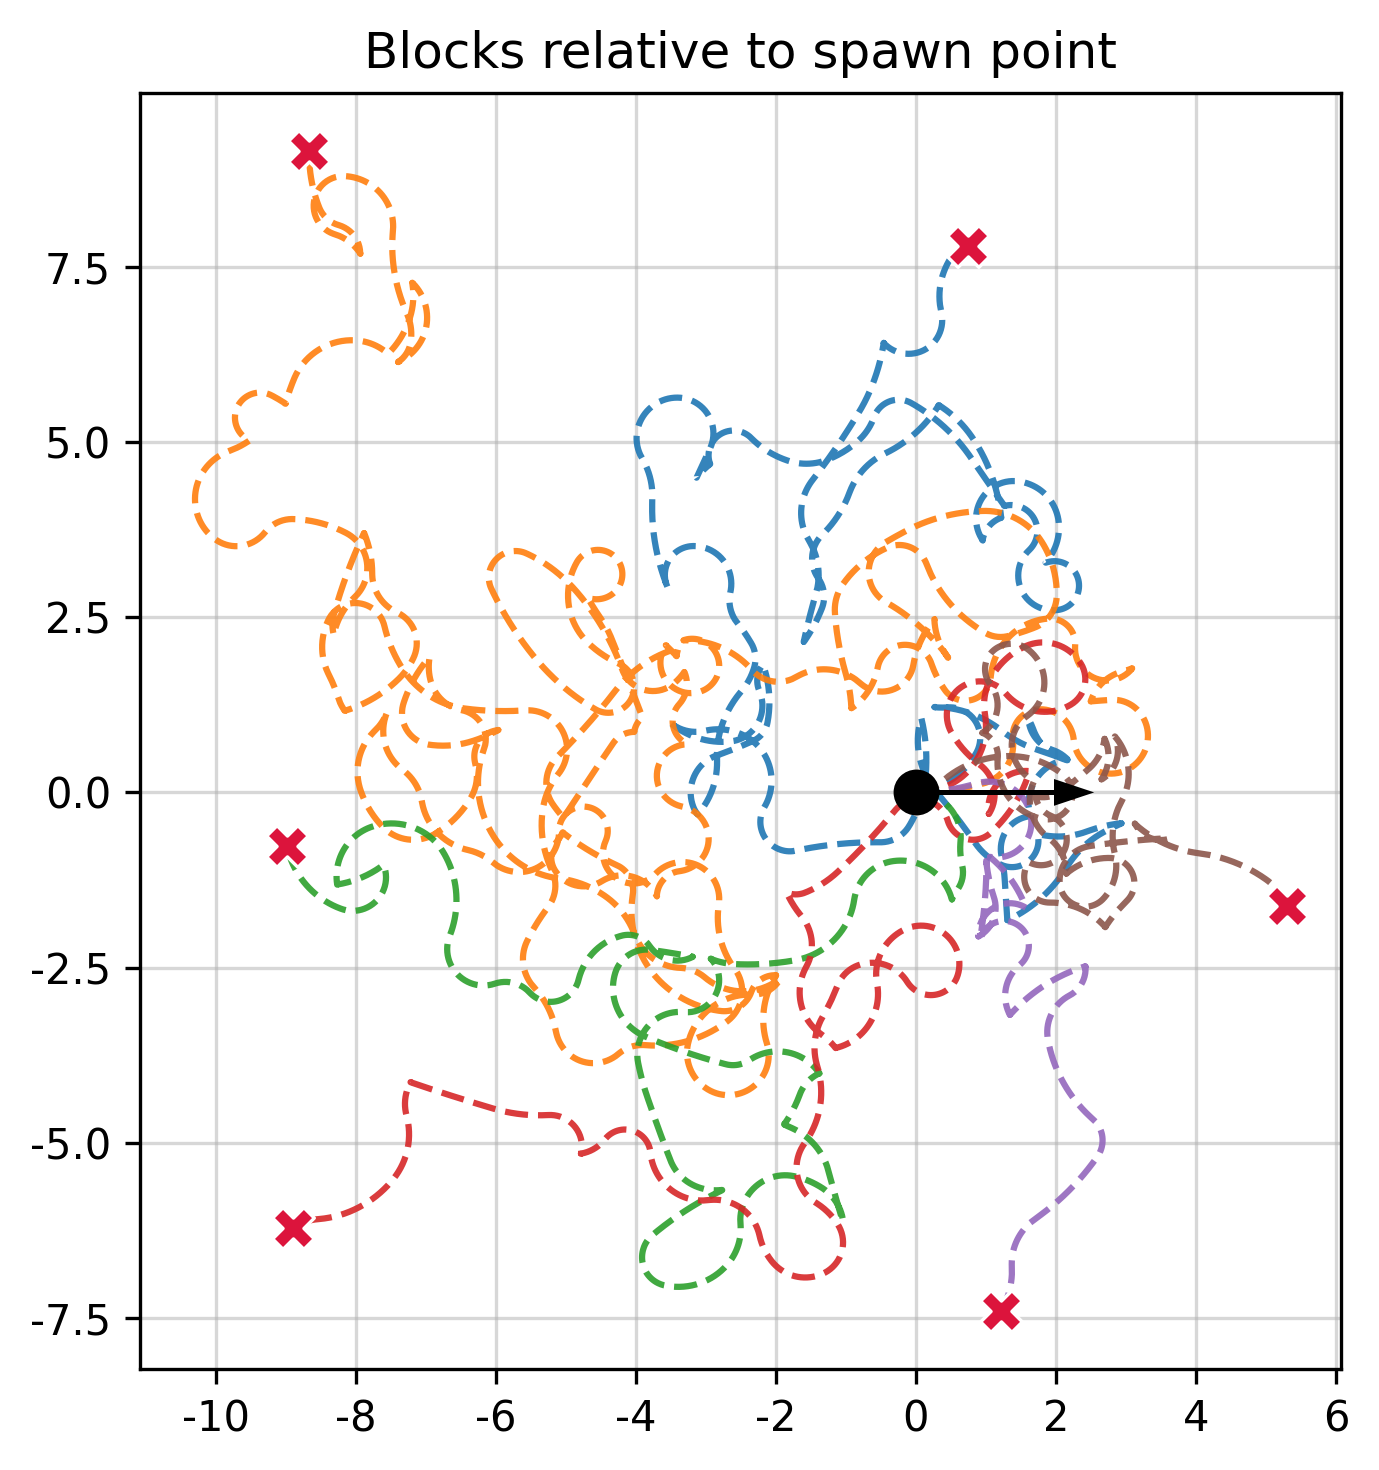

In [104]:
def plot_relative_runs(df, target = 'run'):
    fig, ax = plt.subplots(figsize=(5,5), dpi=300)
    input_cols = [f'ground_truth_odom_{axis}' for axis in ['x', 'y', 'theta']]
    output_cols = ['gt_rel_' + label.rsplit('_', 1)[-1] for label in input_cols]
    df = df.copy()
    def rotate(p):
        angle = -p.iat[0,-1]
        R = np.array([[np.cos(angle), -np.sin(angle)],
                      [np.sin(angle), np.cos(angle)]])
        p[input_cols] = p - p.iloc[0]
        p[input_cols[:2]] = np.squeeze((R @ p.loc[:,input_cols[:2]].T).T).values
        return p

    df[output_cols] = df.groupby(target)[input_cols].progress_apply(rotate)

    setup_topview(ax, fixed=False)
    def show_proof(run):
        x,y,t = run[output_cols].values.T
        ax.plot(x,y, linestyle='--',alpha=0.9)
        #ax.plot(x[-1:],y[-1:], 'x', color='black', zorder=3)
        sns.scatterplot(x=x[-1:],y=y[-1:], style=['x'], alpha=1, color='crimson',s=100, ax=ax, legend=False, zorder=4, markers=['X'])

        #sns.lineplot(x=[x[0], x[0]+np.cos(t[0])*2],y=[y[0], y[0]+np.sin(t[0])*2], color='black', ax=ax)
    ax.plot([0],[0], 'o', color='black', ms=10, zorder=10)
    ax.arrow(0,0,2,0, color='black', head_width=0.3, zorder=10)
    df[df[target].isin([1,4,5,8,9, 12])].groupby(target).progress_apply(show_proof)
    ax.set_title('Blocks relative to spawn point')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.savefig('relative_travel.png')
#     plt.xlim(-12,12)
#     plt.ylim(-12,12)


plot_relative_runs(df, target='big_block')
#reduced = df.groupby('run').apply(lambda x: x.iloc[10:]).reset_index(level=0, drop=True)
#plot_relative_runs(reduced, axes[1])


#axes[1].set_xlim(-2,20)

Let's cut the first 10 iteration to be sure we do not include any precedent run data

In [12]:
# df = reduced
# df = df.groupby('run').filter(lambda x: (x.index[-1]-x.index[0]) > pd.Timedelta(window))
# statistics(df)

### Controlliamo la qualità delle run registrate, hanno tutte senso?

100%|██████████| 6/6 [00:00<00:00, 11.94it/s]


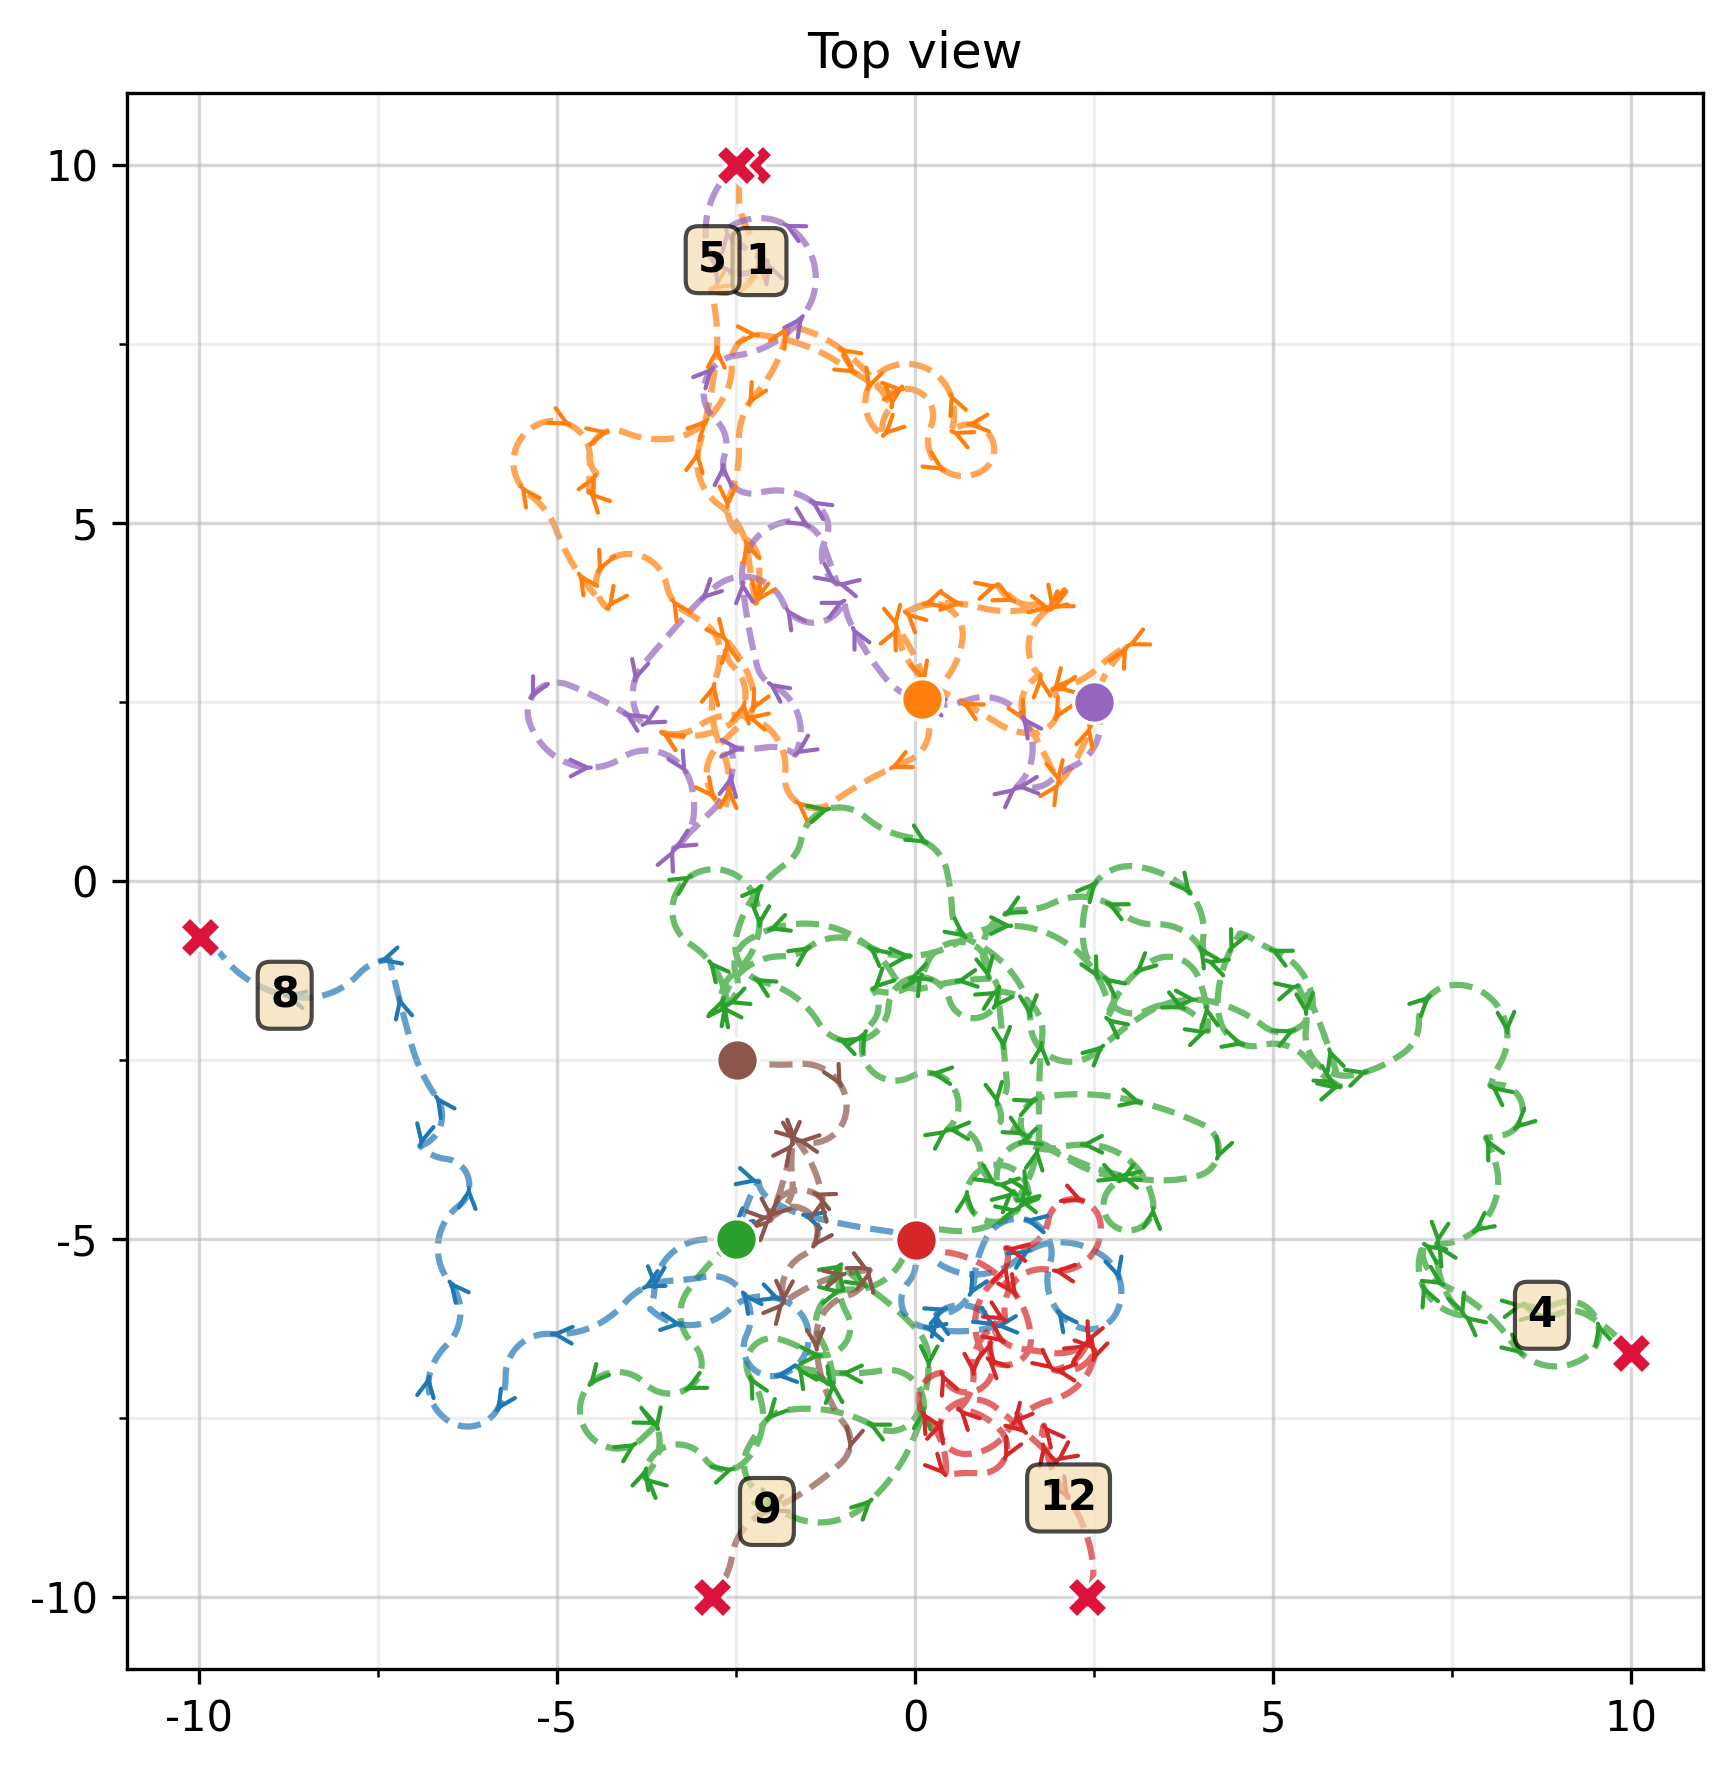

In [99]:
import importlib
import utils_ros
from utils_ros import add_arrow
from functools import partial
importlib.reload(utils_ros)
import random
random.seed(0)
def plot_traces(df, target='run', full=1):
    fig, ax = plt.subplots(figsize=(6,6), dpi=300)
    interesting = [5,4,1,8,9,12]
    setup_topview(ax)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
    colors = [f'C{i}' for i in range(len(interesting))]
    random.shuffle(colors)
    colors = {i:c for i,c in zip(interesting,colors)}
    def f(run):
        if run.iloc[0][target]%full != 0:
            return
        x,y = run[['ground_truth_odom_x','ground_truth_odom_y']].values.T
        #print(x.shape, y.shape, x[0], y[0])
        ax.plot(x,y, linestyle='--', alpha=0.7, zorder=1, color=colors[run.iloc[0][target]])
        add_arrow(ax.lines[-1], x, y, step=100, size=10)

        sns.scatterplot(x=x[:1],y=y[:1], style=['x'], alpha=1, color=colors[run.iloc[0][target]], s=100, ax=ax, legend=False, zorder=4)
        sns.scatterplot(x=x[-1:],y=y[-1:], style=['x'], alpha=1, color='crimson',s=100, ax=ax, legend=False, zorder=4, markers=['X'])
        ax.text(x[-100],y[-100],s=run.iloc[0][target],
               horizontalalignment='center', verticalalignment='center', bbox=props,  weight='bold', zorder=5)

    
    df[df[target].isin(interesting)].groupby(target).progress_apply(f)
    #ax.scatter(x=points[:,0], y=points[:,1])
    
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.savefig('absolute_travel.png')
plot_traces(df, 'big_block',full=1)

In [ ]:
# from datetime import timedelta as td
# run_lengths_time = df.groupby('run').apply(lambda x: (x.index[-1] - x.index[0])).sort_values()
# run_lengths_time


## Occupancy Map


In [ ]:
# from utils_ros import ROBOT_GEOMETRY_FULL, mktransf
# fig, ax = plt.subplots(figsize=(8,8))
# coords = np.stack(np.meshgrid(
#     np.linspace(0, .8, int(.8 / .04)),
#     np.linspace(-.4, .4, int(.8 / .04))
# )).reshape([2, -1]).T
# display(coords.shape)
# ax.set_aspect('equal')
# sns.scatterplot(x=coords[:,0], y=coords[:,1], ax=ax);
# def plot_transform(ax, tr, color='b', length=1, debug=False):
#     origin = (tr @ np.array([0, 0, 1]))[:2]
#     xhat   = (tr @ np.array([length, 0, 1]))[:2]
#     yhat   = (tr @ np.array([0, length/2, 1]))[:2] #(tr @ np.array([0, length, 1]))[:2]

#     ax.arrow(*origin, *(xhat - origin), head_width=0.005, color=color, zorder=3)
#     ax.arrow(*origin, *(yhat - origin), head_width=0.005, color=color,zorder=3, alpha=1)
    
# for r in ROBOT_GEOMETRY_FULL:
#     plot_transform(ax, r, length=0.12)

In [14]:
import occupancy_map
importlib.reload(occupancy_map)
from occupancy_map import compute_occupancy_map

In [15]:
df.columns

Index(['right', 'center', 'image', 'left', 'x', 'y', 'theta', 'center_left',
       'ground_truth_odom_x', 'ground_truth_odom_y', 'ground_truth_odom_theta',
       'run', 'center_right', 'big_block'],
      dtype='object')

In [16]:
import config
importlib.reload(config)
from config import SENSORS
coords = np.stack(np.meshgrid(
    np.linspace(0, .8, int(.8 / .04)),
    np.linspace(-.4, .4, int(.8 / .04))
)).reshape([2, -1]).T
SENSORS

['left', 'center_left', 'center', 'center_right', 'right']

In [150]:
np.random.random((400,1, 2))-np.random.random((1,5,2))

array([[[-0.42892597, -0.80930866],
        [-0.15811113, -0.40476144],
        [-0.47414412, -0.3248134 ],
        [-0.37535488, -0.49153525],
        [ 0.15047875, -0.4844875 ]],

       [[ 0.18621408, -0.0654465 ],
        [ 0.45702892,  0.33910071],
        [ 0.14099593,  0.41904876],
        [ 0.23978517,  0.25232691],
        [ 0.7656188 ,  0.25937466]],

       [[-0.56596704,  0.0828    ],
        [-0.2951522 ,  0.48734721],
        [-0.61118519,  0.56729526],
        [-0.51239595,  0.40057341],
        [ 0.01343767,  0.40762116]],

       ...,

       [[ 0.12730127, -0.62919461],
        [ 0.39811611, -0.22464739],
        [ 0.08208312, -0.14469935],
        [ 0.18087235, -0.3114212 ],
        [ 0.70670598, -0.30437345]],

       [[-0.16384723, -0.15291765],
        [ 0.10696761,  0.25162956],
        [-0.20906538,  0.3315776 ],
        [-0.11027614,  0.16485576],
        [ 0.41555748,  0.17190351]],

       [[ 0.17984983, -0.85843351],
        [ 0.45066467, -0.45388629],
     

In [519]:
(df.groupby('big_block')['run'].count()).sort_values()

big_block
2       172
28     1353
15     1573
20     1618
22     1862
9      2106
19     2385
12     2912
8      3125
5      3348
18     3727
6      4489
30     5372
23     6301
1      6729
14     7859
16     8875
3      9466
7      9940
11    10648
27    11111
17    11417
24    11454
4     12072
25    12149
26    12779
13    13185
21    13229
29    14202
10    35805
Name: run, dtype: int64

big_block
2     0.001236
28    0.007429
15    0.007430
20    0.008668
22    0.008670
8     0.008674
9     0.009909
19    0.011149
5     0.012393
12    0.016108
18    0.016112
23    0.018601
6     0.019834
30    0.021077
1     0.029763
3     0.031013
16    0.034733
14    0.035969
7     0.038459
4     0.040948
11    0.042183
27    0.047148
25    0.050875
17    0.053353
24    0.053353
21    0.053361
13    0.054602
29    0.059570
26    0.063286
10    0.144094
Name: run, dtype: float64
[29 27 26]


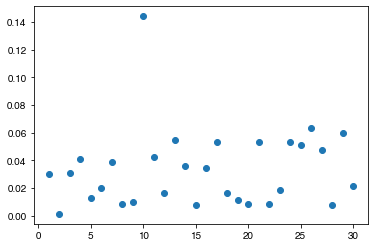

In [521]:
x = (df.groupby('big_block')['run'].nunique()*df.groupby('big_block')['run'].count()).sort_values()
x = x / x.sum()
print(x)
print(np.random.choice(x.index, p=x, size=3, replace=False))
plt.plot(x.index,x.values, 'o')

In [481]:
np.random.choice??

Docstring:
choice(a, size=None, replace=True, p=None)

Generates a random sample from a given 1-D array

        .. versionadded:: 1.7.0

.. note::
    New code should use the ``choice`` method of a ``default_rng()``
    instance instead; see `random-quick-start`.

Parameters
----------
a : 1-D array-like or int
    If an ndarray, a random sample is generated from its elements.
    If an int, the random sample is generated as if a were np.arange(a)
size : int or tuple of ints, optional
    Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
    ``m * n * k`` samples are drawn.  Default is None, in which case a
    single value is returned.
replace : boolean, optional
    Whether the sample is with or without replacement
p : 1-D array-like, optional
    The probabilities associated with each entry in a.
    If not given the sample assumes a uniform distribution over all
    entries in a.

Returns
-------
samples : single item or ndarray
    The generated random samples

Rais

In [567]:
r = np.random.choice(df['big_block'].unique())
run = df[df['big_block'] == 5].iloc[-1900:-1400].copy()

In [333]:
plt.rcParams['legend.handlelength'], plt.rcParams['legend.handleheight']

(2.0, 0.7)

In [366]:
np.array([18,7])*0.5

array([9. , 3.5])

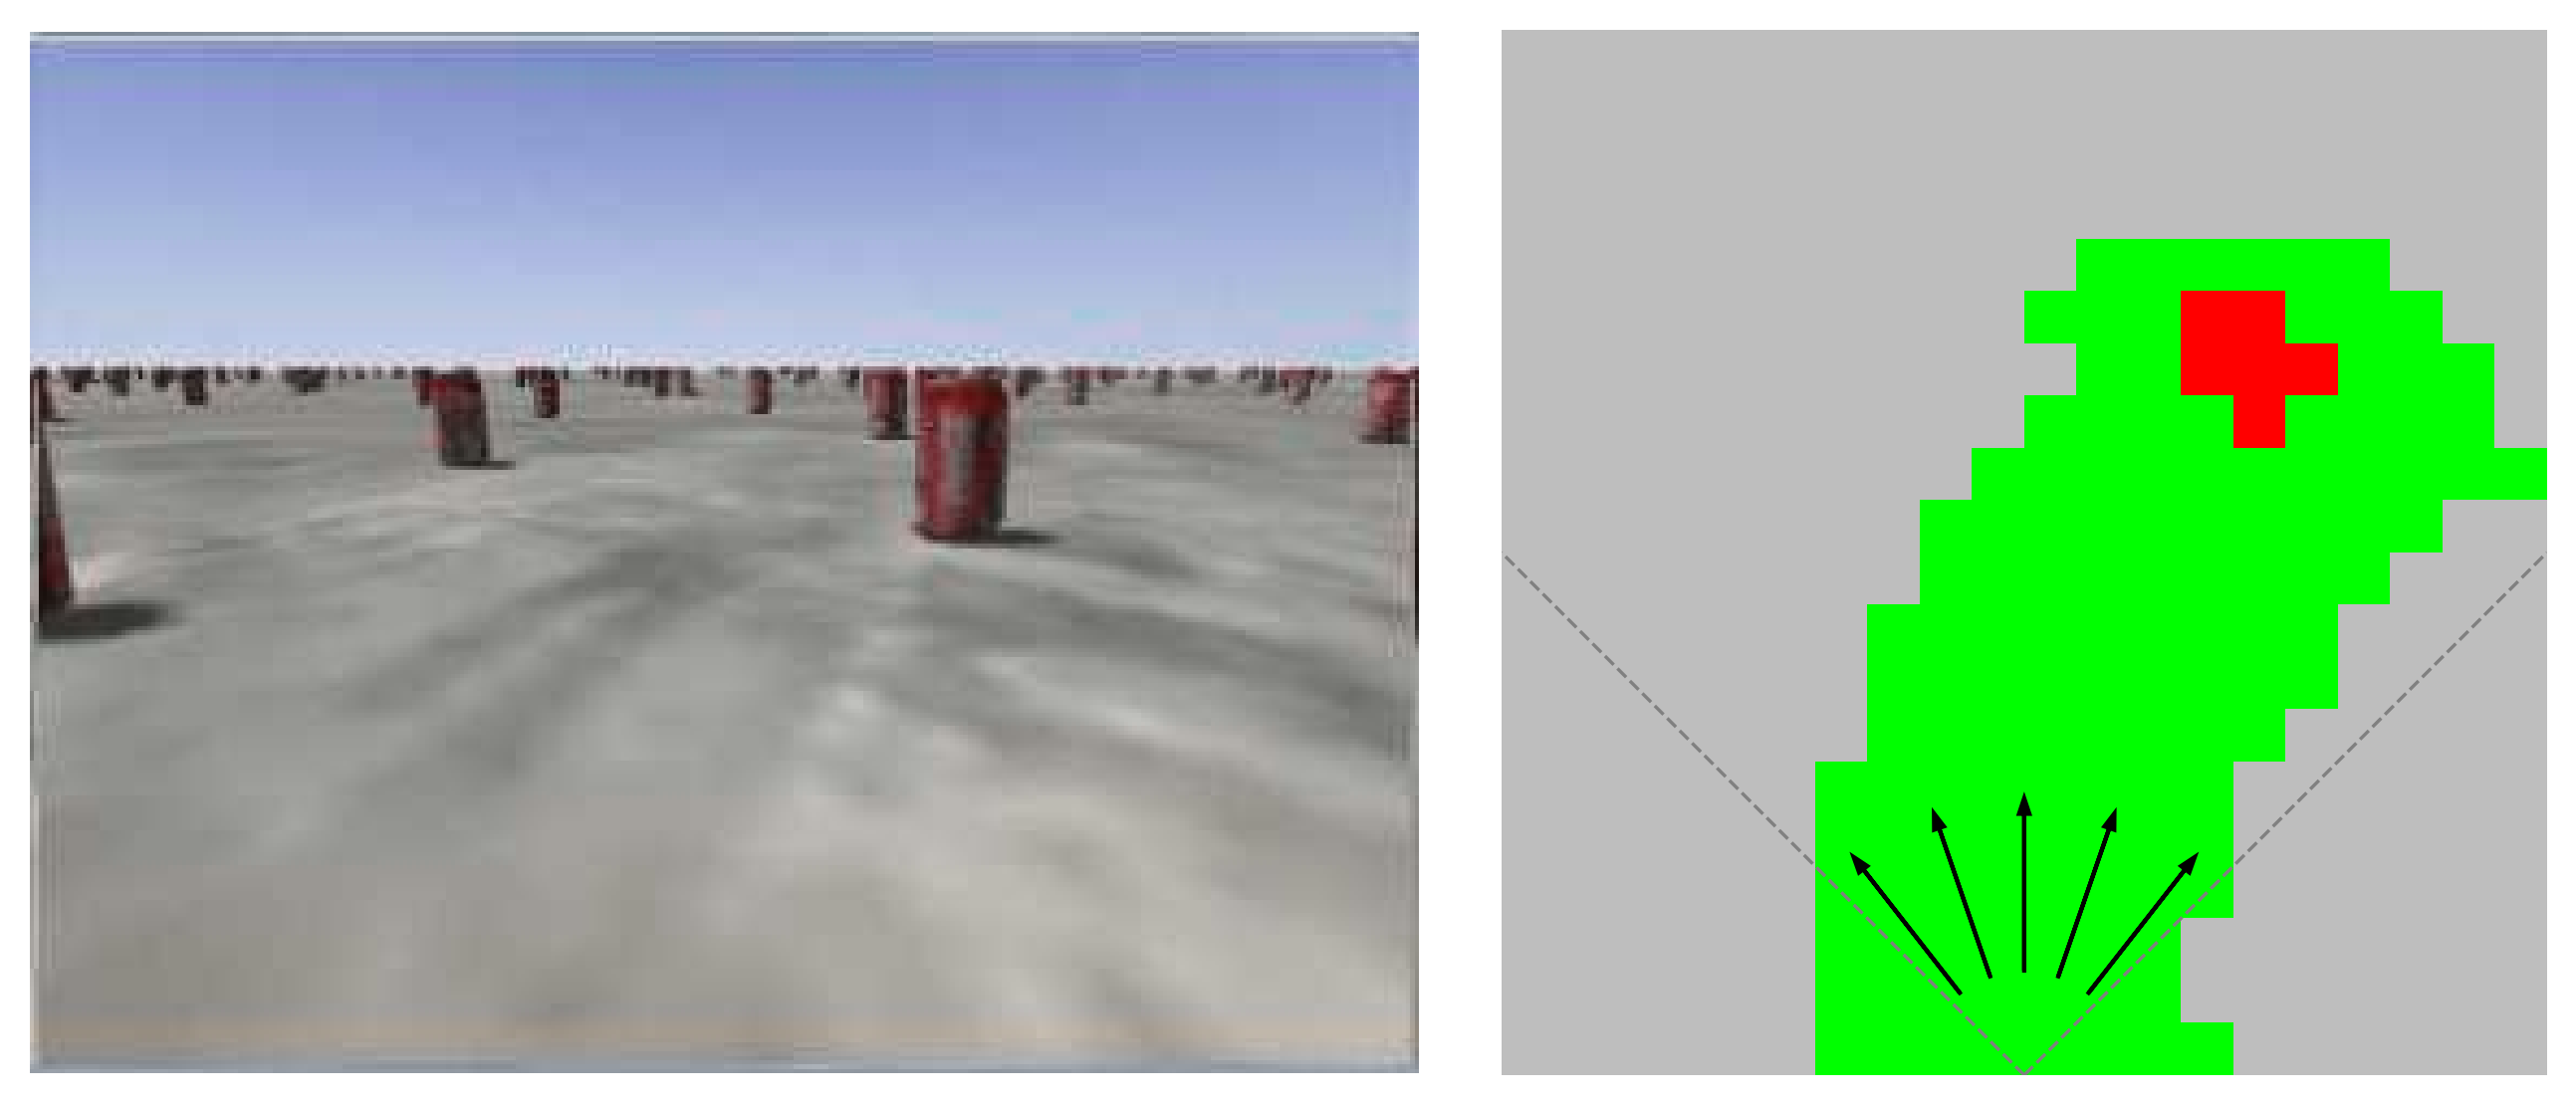

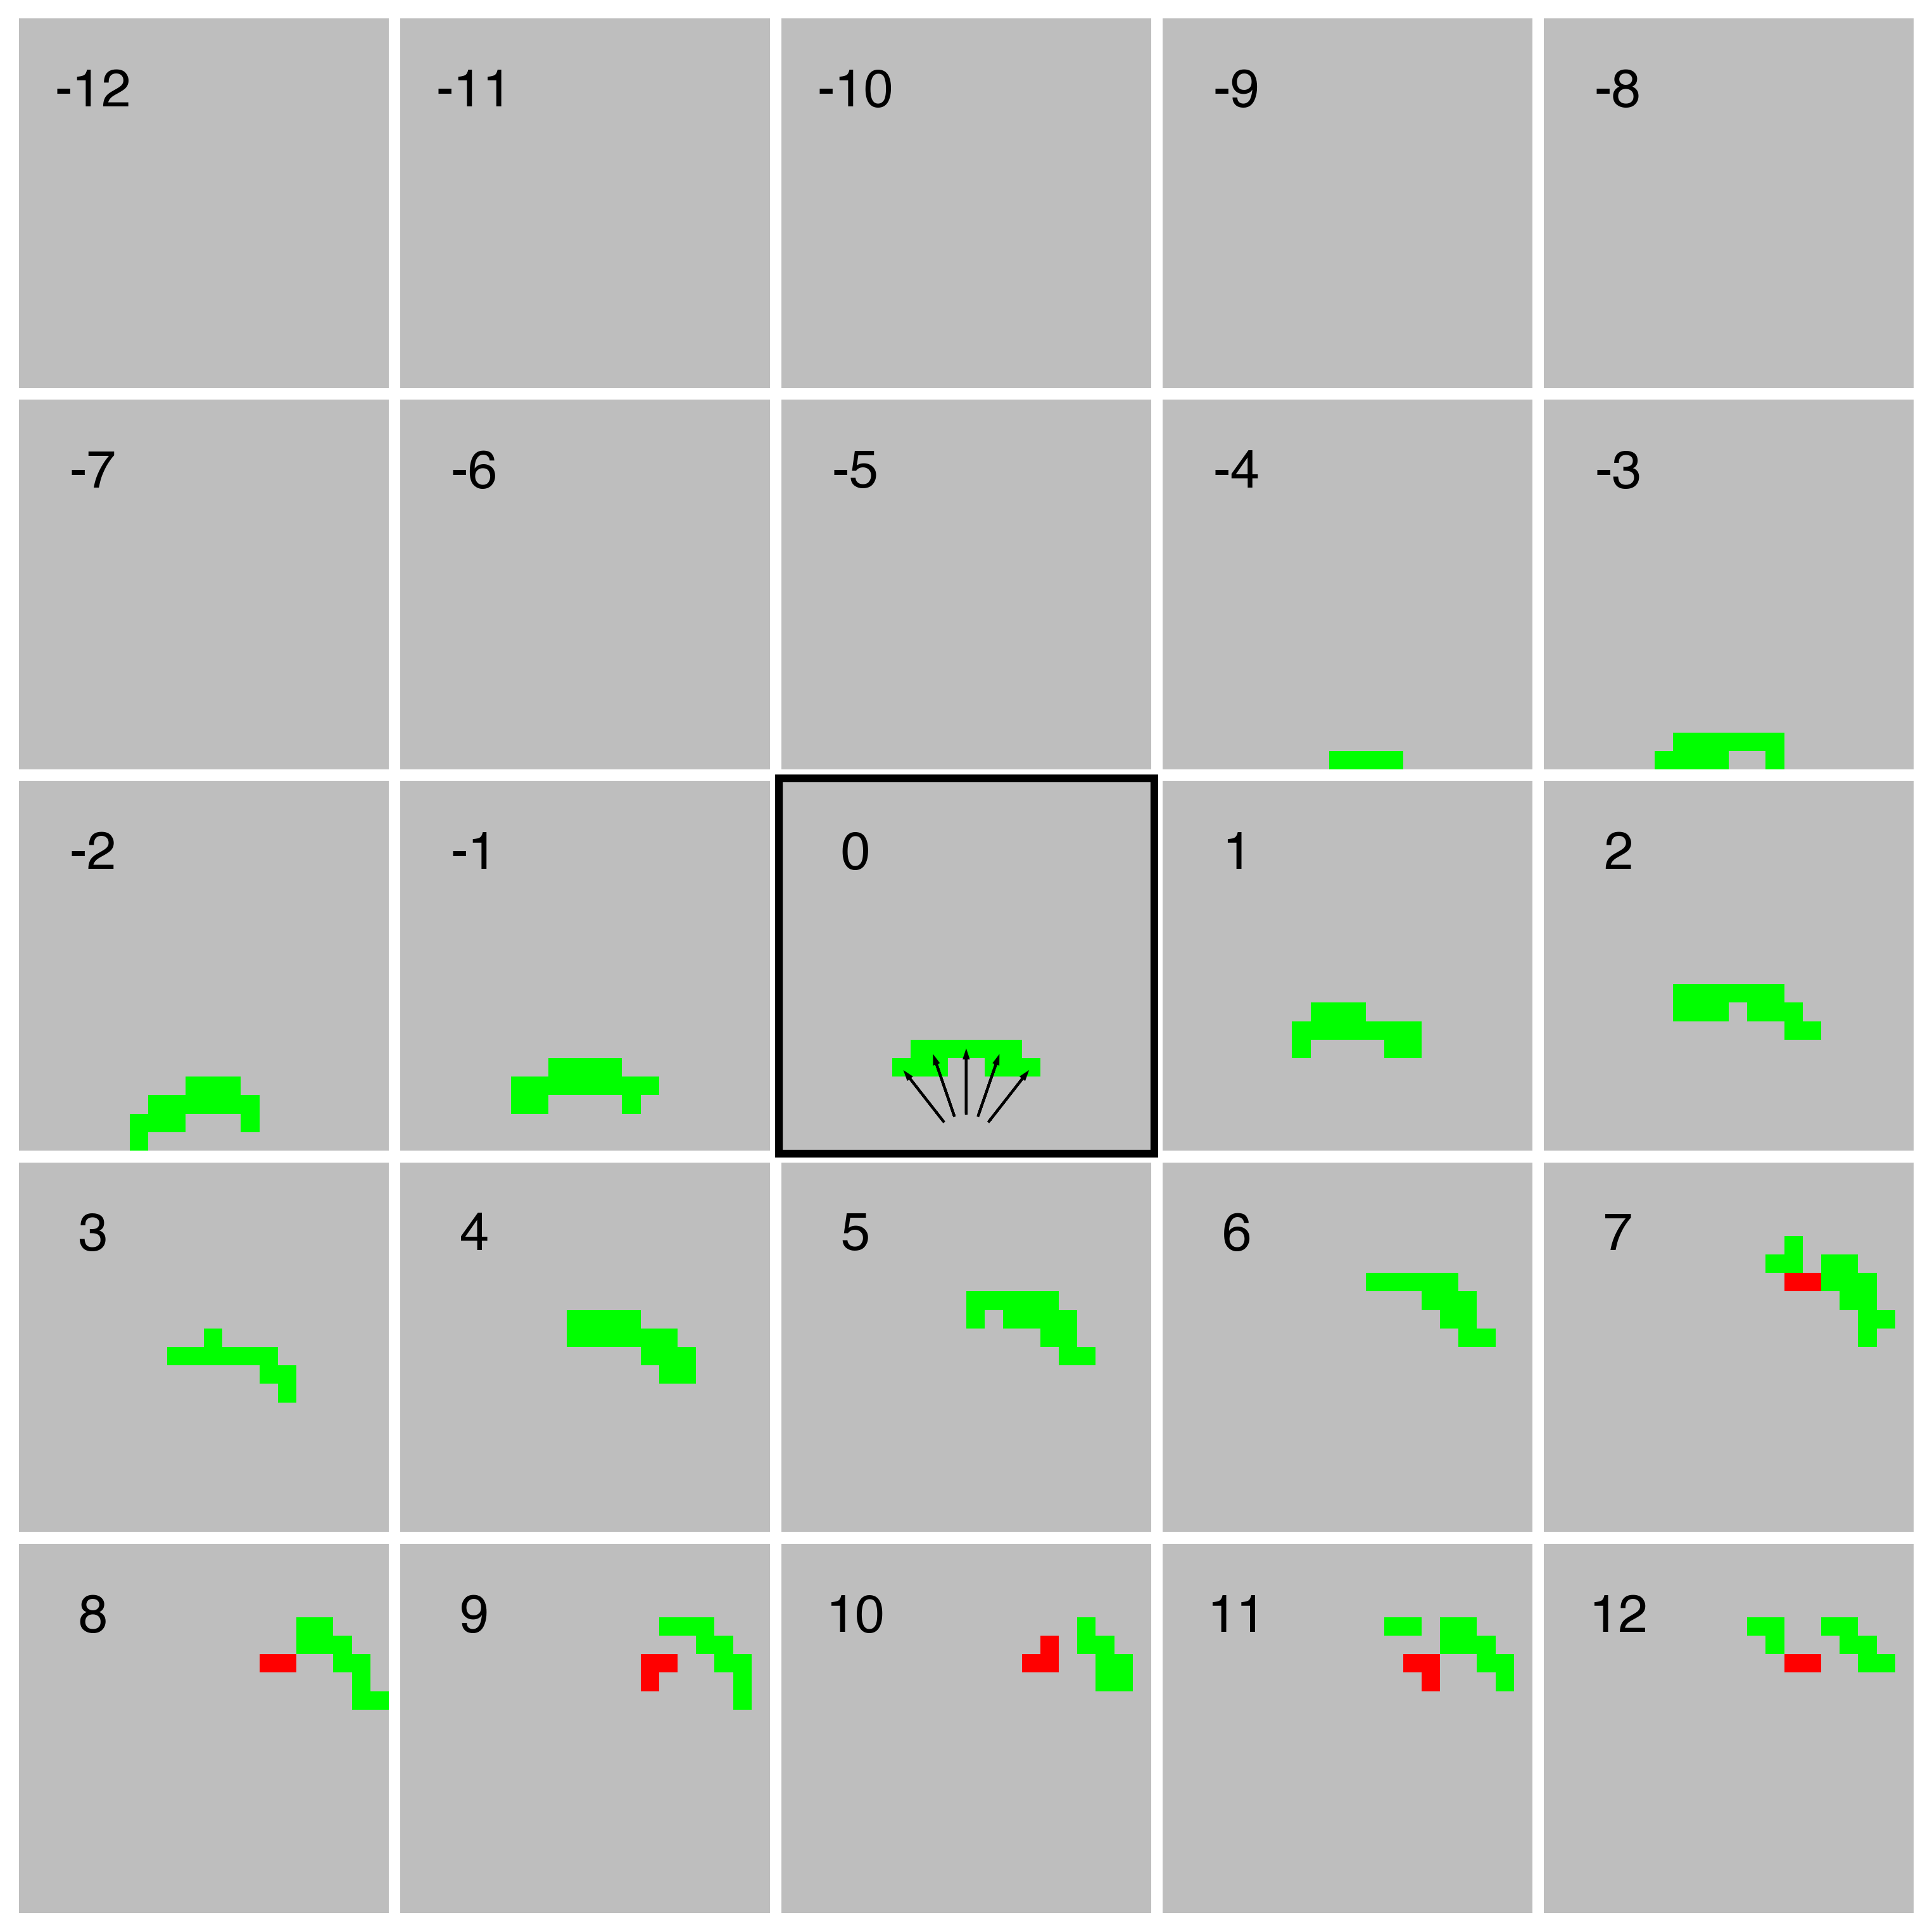

In [408]:
import utils
importlib.reload(utils)
from utils import *
import occupancy_map
importlib.reload(occupancy_map)
from occupancy_map import compute_occupancy_map
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import matplotlib.colors as clr
from matplotlib import rc
    
def show_occupancy_map(run, target_iteration, dpi, delta, legend=True, indicators=True, only_map=False, title='omap_example'):
    
    
    if only_map:
        fig,axs =plt.subplots(1,1, figsize=(9, 3.5), dpi=dpi)
        axs = {1:axs}
    else:
        fig,axs =plt.subplots(1,2, figsize=(9, 3.5), dpi=dpi)
        axs[0].imshow(cv_from_binary(run.iloc[target_iteration]['image']))
        axs[0].axis('off')
        
    x, maps = compute_occupancy_map(run.iloc[target_iteration], run, coords, SENSORS, window, delta)
    x = x[0].reshape(20,20)
    res = np.empty((20, 20, 3), dtype=np.uint8)
    res[x == -1] = (190, 190, 190)
    res[x == 0] = (0, 255, 0)
    res[x == 1] = (255, 0, 0)
    #print(x)
    axs[1].imshow(res)
    axs[1].axis('off')
    
    if indicators:
        ratio = 20 / 0.8
        for r in scaled_full_robot_geometry(ratio):
            plot_transform(axs[1], mktransf((10-0.5, 20-0.5, -np.pi / 2)) @ r, color='black', length=config.max_sensing_distance * ratio, head_width=0.2)

        axs[1].plot([10 / 20, 0], [0, 0.5], linewidth=.8, linestyle='--', color='grey', transform=axs[1].transAxes)
        axs[1].plot([10 / 20, 1], [0, 0.5], linewidth=.8, linestyle='--', color='grey', transform=axs[1].transAxes)

    


    def make_legend_arrow(legend, orig_handle,
                          xdescent, ydescent,
                          width, height, fontsize):
        p = mpatches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.75*height )
        return p


    class HandlerRect(HandlerPatch):

        def create_artists(self, legend, orig_handle,
                           xdescent, ydescent, width, height,
                           fontsize, trans):

            x = width//2-width//3
            y = 0
            w = h = 10

            # create
            p = mpatches.Rectangle(xy=(x, y), width=w, height=h)

            # update with data from oryginal object
            self.update_prop(p, orig_handle, legend)

            # move xy to legend
            p.set_transform(trans)

            return [p]
    # #Create legend from custom artist/label lists
    # axs[1].legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
    #           [label for i,label in enumerate(labels) if i in display]+['Simulation', 'Analytic'])
    if legend:
        #Create custom artists
        fov = plt.Line2D((0,1),(0,0), color='grey', linestyle='--')
        sensor = plt.arrow(0,0,0,0, color='black')

        obst = mpatches.Rectangle((0,0),1,1,facecolor='red')
        free = mpatches.Rectangle((0,0),1,1,facecolor='green')
        unkn = mpatches.Rectangle((0,0),1,1,facecolor='grey')
        axs[1].legend([fov, sensor, obst,free, unkn],['FOV', 'Sensor', 'Obstacle', 'Free Space', 'Unknown'], 
                      loc='upper left', handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),mpatches.Rectangle: HandlerRect()})

    plt.subplots_adjust(0,0,1,1)
    fig.tight_layout(pad=0)
    plt.savefig(f'{title}.png')
    return maps
    
def naked_omap(maps, dpi):
    
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    sqrt = int(np.sqrt(len(maps)))
    fig, axs = plt.subplots(sqrt,sqrt, figsize=(10,10), dpi=dpi)
    axs = np.array(axs).flatten()
    v = maps[:sqrt**2]
    for i, m in enumerate(v):
        x = np.flip(np.rot90(m.reshape(20,20)),axis=1)
        res = np.empty((20, 20, 3), dtype=np.uint8)
        res[x == -1] = (190, 190, 190)
        res[x == 0] = (0, 255, 0)
        res[x == 1] = (255, 0, 0)
        axs[i].imshow(res)
        axs[i].axis('off')
        #s=f'$x_{{{i-int(len(v)/2)}}}$'
        axs[i].text(0.2,0.80, s=i-int(len(v)/2), color='black', ha="center", va="center", size=20, transform=axs[i].transAxes)
        
        if i-int(len(v)/2) == 0:
            axs[i].patch.set_edgecolor('black')  
            axs[i].patch.set_linewidth('5') 
            axs[i].axis('on')
            axs[i].set_xticks([],minor=[])
            axs[i].set_yticks([],minor=[])
            ratio = 20 / 0.8
            for r in scaled_full_robot_geometry(ratio):
                plot_transform(axs[i], mktransf((10-0.5, 20-0.5, -np.pi / 2)) @ r, color='black', length=config.max_sensing_distance * ratio, head_width=0.2)

    plt.subplots_adjust(0,0,1,1)
    fig.tight_layout(pad=0.1)
    plt.savefig('omap_before_agg.png')
    plt.show()

    
run = df[df['big_block'] == 5].iloc[-1900:-1400].copy()

dpi = 300
maps = show_occupancy_map(run, 47, dpi, delta=0.04, legend=False)
#maps2 = show_occupancy_map(run, 47, dpi, delta=0.4, legend=False, indicators=False, only_map=True, title='lower_delta')
#maps2 = show_occupancy_map(run, 47, dpi, delta=0.02, legend=False, indicators=False, only_map=True, title='higher_delta')
naked_omap(maps[0::4],dpi)
#naked_omap(maps2[0::4],dpi)

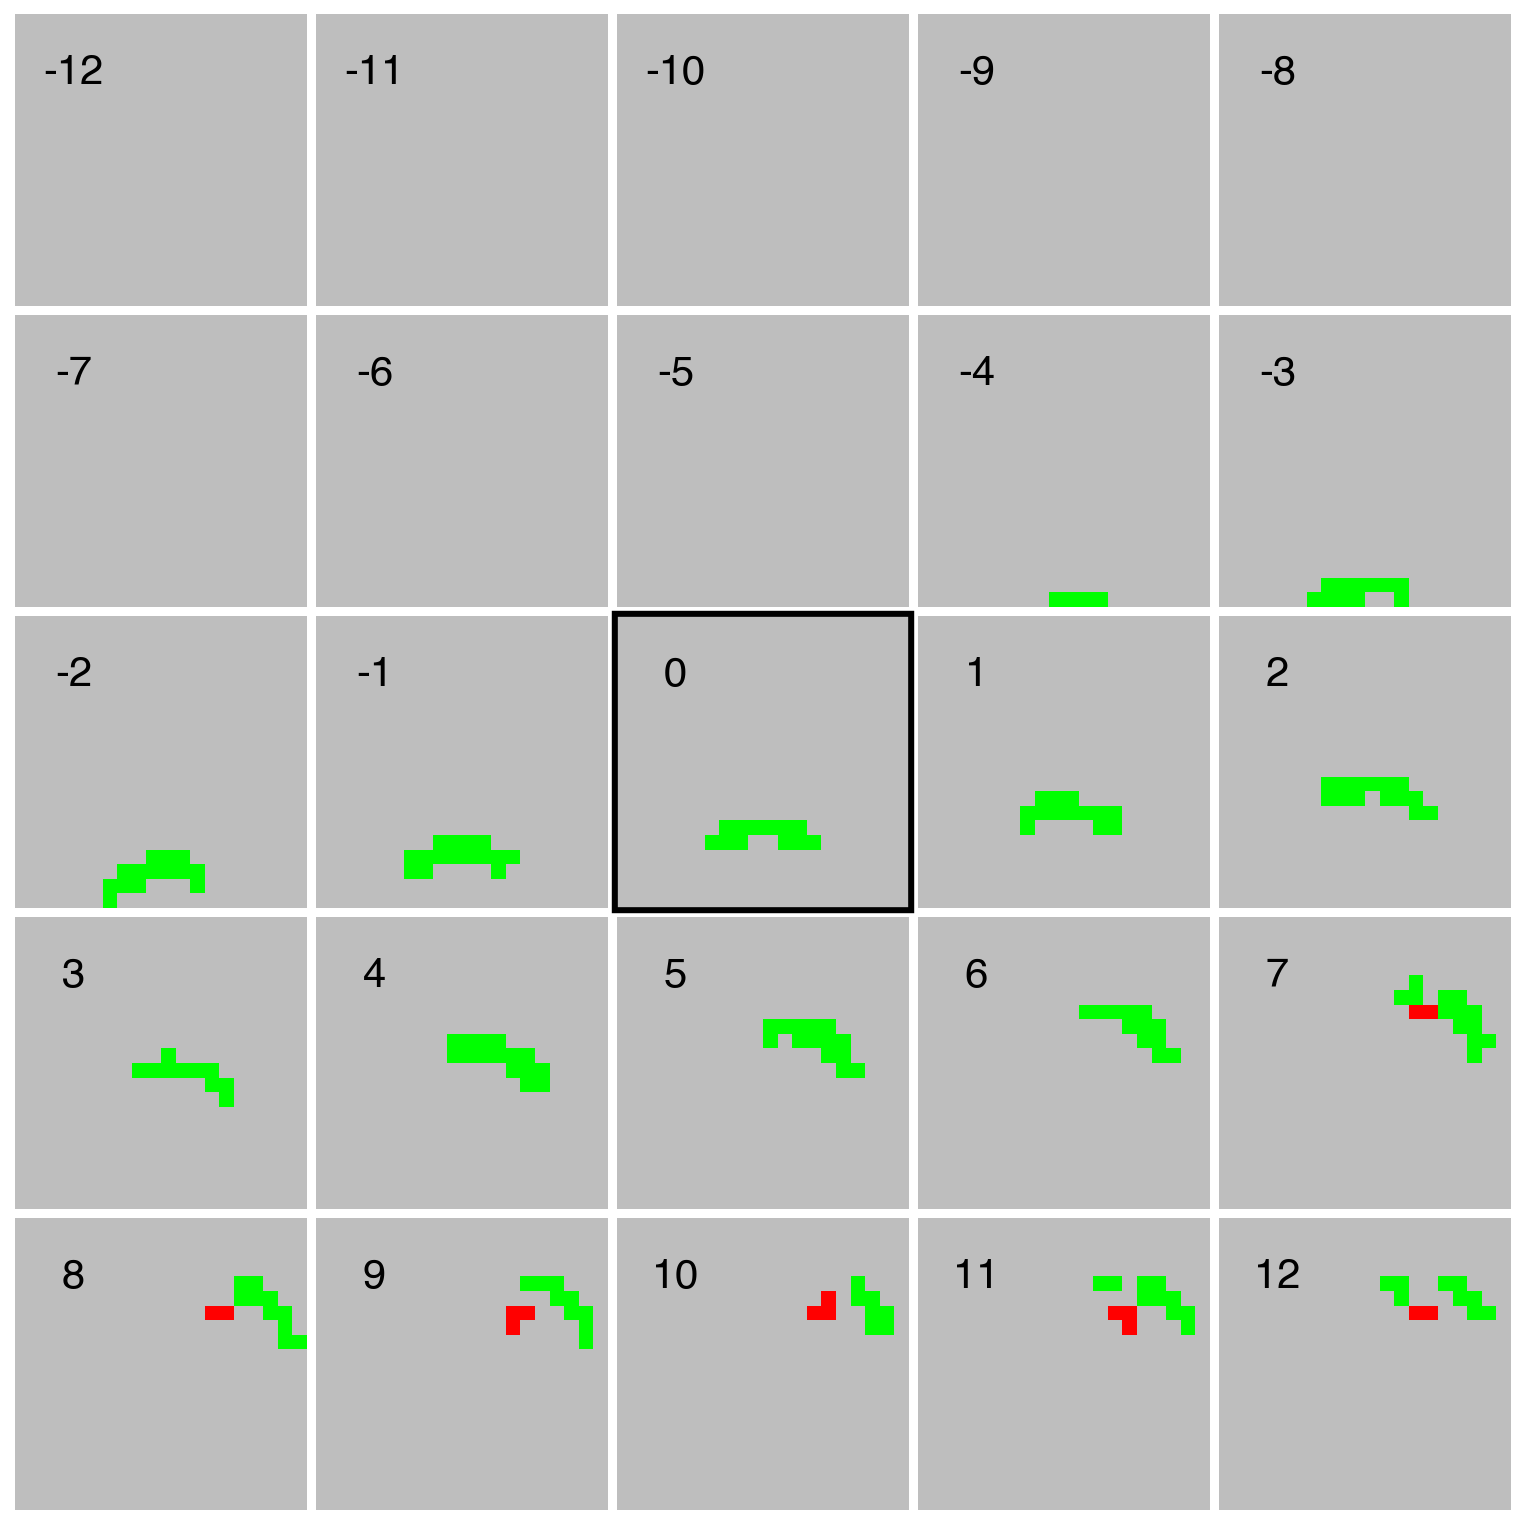

In [238]:
!pwd

/Users/ste/code/active_learning/notebooks


In [571]:
window = '8s'
delta = 0.04
import occupancy_map
importlib.reload(occupancy_map)
from occupancy_map import compute_occupancy_map
occ_map = run.progress_apply(compute_occupancy_map, axis=1, args=(run, coords, SENSORS, window, delta))
if 'target_map' in run.columns:
    run['target_map'] = occ_map
else:
    run = pd.concat([run, occ_map],axis=1)

100%|██████████| 500/500 [00:12<00:00, 40.65it/s]


In [608]:
import animator
import utils
# importlib.reload(utils)
importlib.reload(animator)
save_path = os.path.join(d.path,'single_runs',f'omap_big_block{r}.mp4')
animator.Animator(run, targets, rate=30, save_path=save_path, s=slice(-30,None,None),
                  extra_info={'Time window':window, ' delta': delta})
Video(save_path)

/usr/local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Process complete. Video file saved to: ../history/1231-002801/single_runs/omap_big_block21.mp4


In [570]:
run

,right,center,image,left,x,y,theta,center_left,ground_truth_odom_x,ground_truth_odom_y,ground_truth_odom_theta,run,center_right,big_block,target_map
time,,,,,,,,,,,,,,,
2020-12-31 00:37:05.471957380,0.120000,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,2.985265,11.103330,2.508267,0.12,-3.198635,1.516544,-1.021357,84,0.12,5,"([[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -..."
2020-12-31 00:37:05.603379238,0.120000,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,2.985265,11.103330,2.508267,0.12,-3.191039,1.503801,-1.045029,84,0.12,5,"([[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -..."
2020-12-31 00:37:05.738604076,0.120000,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,2.961830,11.121546,2.453418,0.12,-3.183746,1.490881,-1.068714,84,0.12,5,"([[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -..."
2020-12-31 00:37:05.871561098,0.120000,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,2.950496,11.131129,2.425976,0.12,-3.176761,1.477791,-1.092411,84,0.12,5,"([[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -..."
2020-12-31 00:37:06.004290405,0.120000,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,2.939428,11.141021,2.398526,0.12,-3.170088,1.464539,-1.116114,84,0.12,5,"([[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 00:38:12.542784981,0.032299,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,2.386844,10.200897,-2.047352,0.12,-1.674563,1.765013,0.440348,86,0.12,5,"([[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -..."
2020-12-31 00:38:12.674941970,0.032880,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,2.386865,10.200938,-2.018231,0.12,-1.674599,1.764993,0.465319,86,0.12,5,"([[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -..."
2020-12-31 00:38:12.805081514,0.032190,0.12,"NUMPY v {'descr': '|u1', 'fortran_order': Fa...",0.12,2.386884,10.200979,-1.989096,0.12,-1.674641,1.764969,0.490386,86,0.12,5,"([[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -..."


In [561]:
Video(save_path)

Looks healthy, process the whole dataset

In [44]:
occ_map = df.groupby('big_block').progress_apply(lambda x: x.apply(compute_occupancy_map, axis=1, args=(x, coords, SENSORS, window, delta)))
if 'target_map' in df.columns:
    df['target_map'] = occ_map
else:
    df = pd.concat([df, occ_map],axis=1)

100%|██████████| 30/30 [2:01:51<00:00, 243.73s/it]  


In [126]:
d.path

'../history/1231-002801'

In [137]:
val_ids = [25,4]
test_ids = [26,24]

test_df = df[df['big_block'].isin(test_ids)]
val_df = df[df['big_block'].isin(val_ids)]
train_df = df[df['big_block'].isin(set(df['big_block'].unique())-set(test_ids)-set(val_ids))]
len(train_df), len(val_df), len(test_df)
train_df.to_pickle(os.path.join(d.path,'train.pkl'))
val_df.to_pickle(os.path.join(d.path,'valid.pkl'))
test_df.to_pickle(os.path.join(d.path,'test.pkl'))

In [155]:
df.to_pickle(os.path.join(d.path,'dataset.pkl'))

In [555]:
test = pd.DataFrame({'runs':df.groupby('big_block')['run'].nunique()**2, 'iterations': df.groupby('big_block')['run'].count()})
test['ratio'] = test['runs']**2 / test['iterations']
test['p'] = test['ratio'] / test['ratio'].sum()
pos = np.random.choice(test.index, p=test['p'], size=len(x), replace=False)
test = test.reindex(pos)
test['pos'] = np.arange(len(x))
test

,runs,iterations,ratio,p,pos
big_block,,,,,
29,2304,14202,373.779468,4.582793e-02,0
26,2601,12779,529.399875,6.490806e-02,1
21,1849,13229,258.432308,3.168558e-02,2
25,1681,12149,232.592065,2.851739e-02,3
13,1936,13185,284.269700,3.485342e-02,4
10,13456,35805,5056.945566,6.200163e-01,5
24,1849,11454,298.480967,3.659582e-02,6
27,1444,11111,187.664117,2.300891e-02,7
16,784,8875,69.257014,8.491386e-03,8


big_block
1      6729
2       172
3      9466
4     12072
5      3348
6      4489
7      9940
8      3125
9      2106
10    35805
11    10648
12     2912
13    13185
14     7859
15     1573
16     8875
17    11417
18     3727
19     2385
20     1618
21    13229
22     1862
23     6301
24    11454
25    12149
26    12779
27    11111
28     1353
29    14202
30     5372
Name: run, dtype: int64

In [537]:
x = (df.groupby('big_block')['run'].nunique()**2/df.groupby('big_block')['run'].count()).sort_values()

ep = np.random.choice(x.index, p=x, size=len(x), replace=False)
print(ep)
test = pd.DataFrame({'p':x.values}, index=x.index)
pd.DataFrame({'p':x.values}, index=x.index)

[ 4 25 13 27 10 29 17  7 26  5  1  2 14 23 11 21 18 12 30  6 19 24 28 22
  3 20 16  9  8 15]


NameError: name 'mktransf' is not defined

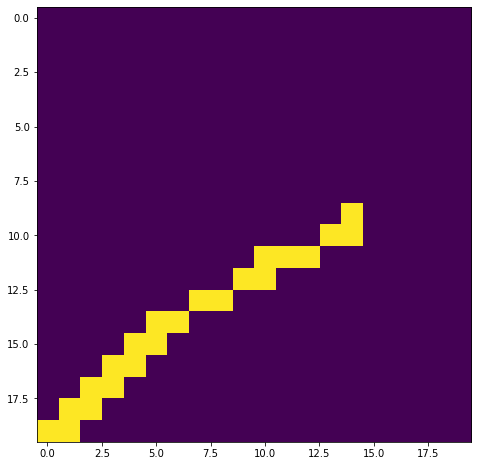

In [52]:
from utils_ros import quaternion2yaw,scaled_full_robot_geometry

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(np.rot90(df['target_map'].iloc[0].reshape(20,20)))
def plot_transform(ax, tr, color='b', length=1):
    origin = (tr @ np.array([0, 0, 1]))[:2]
    xhat   = (tr @ np.array([length, 0, 1]))[:2]
    yhat   = (tr @ np.array([0, 0, 1]))[:2] #(tr @ np.array([0, length, 1]))[:2]

    ax.arrow(*origin, *(xhat - origin), head_width=0.5, color=color,zorder=3, capstyle='projecting')
    ax.arrow(*origin, *(yhat - origin), head_width=0.005, color=color,zorder=3, alpha=0.02)

ratio = 20/0.8

custom = scaled_full_robot_geometry(ratio)
    
for r in custom:
    plot_transform(ax, mktransf((10,20,-np.pi/2))@r, color='red',length=0.12*ratio)
plt.show()

In [558]:
from animator import Animator

run = df[df['run'] == 30].copy()
save_path = os.path.join(d.path,'single_runs',f'omap_test.mp4')
Animator(run, targets, rate=30, save_path=save_path, s=slice(-100,None,None),extra_info={'Time window':window, ' delta': delta})
Video(save_path)

Process complete. Video file saved to: ../history/1231-002801/single_runs/omap_test.mp4


TypeError: 'tuple' object is not callable

In [560]:
Video(save_path)

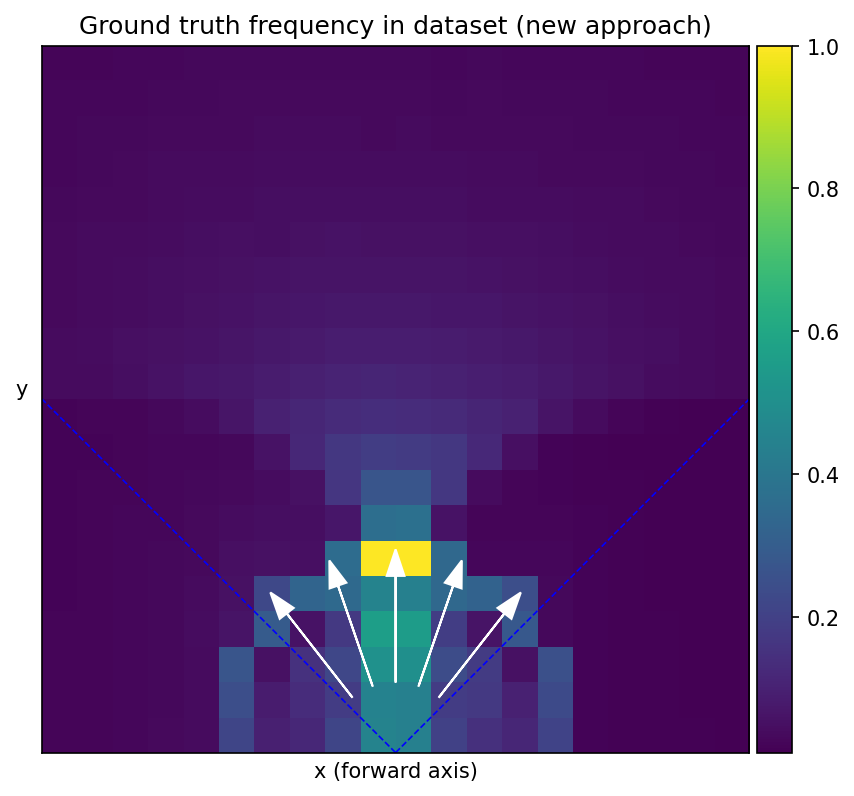

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils_ros import scaled_full_robot_geometry, mktransf
def compute_map_density(df, title=None):
    a = np.array([np.array(x).reshape(20,20) for x in df['target_map'].values])
    a[a == 0] = 1
    a[a == -1] = 0
    b = a.sum(axis=0) / a.shape[0]
    fig, ax = plt.subplots(figsize=(5,5),dpi=150)
    #ax = sns.heatmap(data=b.reshape(20,20), cbar=True)
    im = ax.imshow(b.reshape(20,20))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, ax=ax, cax=cax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('x (forward axis)')
    ax.set_ylabel('y', rotation=0, labelpad=10)
    ratio = 20 / 0.8
    for r in scaled_full_robot_geometry(ratio):
        plot_transform(ax, mktransf((10-0.5, 20-0.5, -np.pi / 2)) @ r, color='white', length=config.max_sensing_distance * ratio)

    ax.plot([10 / 20, 0], [0, 0.5], linewidth=.8, linestyle='--', color='blue', transform=ax.transAxes)
    ax.plot([10 / 20, 1], [0, 0.5], linewidth=.8, linestyle='--', color='blue', transform=ax.transAxes)
    ax.set_aspect('equal')
    if title is not None:
        ax.set_title(title)
    plt.subplots_adjust(0,0,1,1)
    # plt.savefig()
    plt.show()
compute_map_density(df, title='Ground truth frequency in dataset (new approach)')

In [ ]:
(df['sensor'] == 0.12).value_counts(normalize=True)*100

In [ ]:
df['out_of_map'].value_counts(normalize=True)*100

In [ ]:
#dataset = df.loc[~df['out_of_map'],['run','image','target_map']].reset_index(drop=True).copy()
df.to_pickle(os.path.join(d.path, 'dataset.pkl'))
#del dataset

In [ ]:
import scipy
from matplotlib.colors import LinearSegmentedColormap
from utils import mktransf
def plot_last_omap(df, run_id):
    if 'target_map' not in df.columns:
        print('No occupancy maps')
        return
    run = df[df['run'] == run_id].copy()
    run['gt_pose'] = run[['ground_truth_odom_x', 'ground_truth_odom_y', 'ground_truth_odom_theta']].apply(mktransf, axis=1)

    def plot_transform(ax, tr, color='b', length=1, debug=False):
        origin = (tr @ np.array([0, 0, 1]))[:2]
        xhat   = (tr @ np.array([length, 0, 1]))[:2]
        yhat   = (tr @ np.array([0, 0, 1]))[:2] #(tr @ np.array([0, length, 1]))[:2]

        ax.arrow(*origin, *(xhat - origin), head_width=0.005, color=color, zorder=3)
        ax.arrow(*origin, *(yhat - origin), head_width=0.005, color=color,zorder=3, alpha=0.02)

    fix, axes = plt.subplots(1,2, figsize=(10,5))
    #fig.tight_layout(w_pad=0.1)
    plt.subplots_adjust(top=0.9,wspace=0.1)
    
    ax = axes[1]
    omap = run.iloc[-1]['target_map']
    
    myColors = ('grey', (0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    sns.heatmap(data=omap.reshape(20,20), ax=ax, cmap=cmap, linecolor='lightgray')
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    colorbar.set_ticklabels(['unknown', 'obstacle', 'no obstacle'])
    
    ax.arrow(0.1,0.5, 0, 0.3, color='white', head_width=0.02, transform=ax.transAxes)
    ax.arrow(0.1,0.5, 0.3, 0, color='white', head_width=0.02, transform=ax.transAxes)

    #ax.arrow(0,0, , head_width=0.005, color=color,zorder=3, alpha=0.02)
    ax.set_title('Last occupancy map')
    ax.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_aspect('equal')
    
    ax = axes[0]
    #setup_topview(ax)
    for a in run['gt_pose'].values[-100::1]:
        plot_transform(ax, a, color='b',length=0.10)
    ax.set_title('Top view of poses')
    
    x,y = run[['ground_truth_odom_x','ground_truth_odom_y']].values.T
    sns.lineplot(x=x[-20:],y=y[-20:], linestyle='--', alpha=0.8, color='grey', ax=ax, zorder=1)
    #add_arrow(ax.lines[-1], x[-20:], y[-20:], step=200)

    #sns.scatterplot(x=x[:1],y=y[:1], style=['x'], alpha=1, color='crimson', ax=ax, legend=False, zorder=2, s=200, label='Start')
    x_last,y_last=x[-1:],y[-1:]
    sns.scatterplot(x=x[-1:],y=y[-1:], style=['x'], alpha=1, color='crimson', ax=ax, legend=False, zorder=4, markers=['X'], s=200, label='Stop')
    
    obst = points[scipy.spatial.distance.cdist( points, np.array([x_last, y_last]).T ).argmin()]
    #ax.scatter(x=obst[0], y=obst[1], s=200, color='crimson')
    
    ax.add_artist(plt.Circle(obst, radius=0.08, facecolor='red', linestyle='--', alpha=0.5))
    ax.add_artist(plt.Circle(obst, radius=0.3, facecolor='none', edgecolor='black', linestyle='--', alpha=0.5))
    ax.add_artist(plt.Circle(obst, radius=0.1, facecolor='none', edgecolor='black', linestyle='--'))

    extent = 0.3
    #ax.set_xlim(x_last[0]-extent,x_last[0]+extent)
    ax.set_xlim(ax.get_xlim()[0]-extent, ax.get_xlim()[1]+extent)
    ax.set_ylim(y_last[0]-extent,y_last[0]+extent)
    ax.set_aspect('equal')

    #plt.autoscale(enable=True, axis='both', tight=None)
    plt.suptitle(f'Final part of run #{run_id}')
    
plot_last_omap(run_id=119)

In [ ]:
import matplotlib.patches as patches
n = 16
subset = np.random.choice(df['run'].unique(),n)
plt.close()
fig, axs = plt.subplots(4,4, figsize=(10,10))
run_axs = {s:ax for s, ax in zip(subset, np.array(axs).flatten())}
target_runs = df[df['run'].isin(subset) & df['meaningful_omap'].any()]# & df['meaningful_omap'].any() & ()]
def plotter(x):
    run_id = x.iloc[0]['run']
    ax = run_axs[run_id]
    omap = x.loc[x['meaningful_omap'][::-1].idxmax(),'target_map']
    sns.heatmap(data=omap.reshape(20,20), ax=ax, cbar=False)

    ax.axis('off'), ax.get_xaxis().set_visible(False), ax.get_yaxis().set_visible(False)
    ax.add_patch(patches.Rectangle((0.,0.),1,1, linewidth=5, edgecolor='white', facecolor='none', transform=ax.transAxes))
    ax.text(0.5,0.1, s=str(run_id), transform=ax.transAxes, weight='bold', color='white', size=15, horizontalalignment='center', verticalalignment='center')

target_runs.groupby('run').apply(plotter)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.show();

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
import numpy as np
fig = plt.figure(figsize=(10,7.5))
gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[20,1], height_ratios=[1])
ax = plt.subplot(111)

## data
xx = np.linspace(1,100,num=100) + 20 * np.random.normal(0,1,100)
yy = np.linspace(1,100,num=100) + 10 * np.random.normal(0,1,100)

## scatter
sc = ax.scatter(xx, yy, s=250, alpha=0.35, zorder=100)
ax.plot(np.linspace(-100,200,301), np.linspace(-100,200,301),)
ax.set_xlim((0, 100))
ax.set_ylim((0, 100))
ax.grid(linestyle="--", zorder=10)

## zoom
axins = zoomed_inset_axes(ax, 2, loc="upper left")
scins = axins.scatter(xx, yy, s=100, alpha=0.35, zorder=50, marker=".", c="red")
axins.plot(np.linspace(-100,200,301), np.linspace(-100,200,301), c="red")
axins.set_xlim((70, 90))
axins.set_ylim((70, 90))
mark_inset(ax, axins, loc1=1, loc2=4, fc="none", ec="0.5")
axins.grid(linestyle="--", zorder=50)
plt.show()

In [ ]:
# sns.histplot(data=df.groupby('run').apply(lambda x: x['sensor'].astype(int).sum()*100/len(x)));

In [ ]:
# def f(x):
#     x = x[5:]
#     multiplier = 2.
#     coeff = (x.index[-1]-x.index[0]).nanoseconds/len(x)
#     diff = x['ground_truth_odom_theta'].diff() * coeff
#     mask = diff.fillna(0).between(-0.1, 0.1)
    
#     blocks = (mask.shift() != mask).cumsum().astype(int)
#     #assert(blocks.value_counts()
    
#     x['rotating'] = False
#     if len(blocks.unique()) >= 2:
#         x.loc[(blocks == 2).idxmax():, 'rotating'] = True
#     return x
# df2 = df.groupby('run').apply(f).reset_index(level=0,drop=True)
# statistics(df2)
# df2 = df2.groupby('run').apply(lambda x: x.assign(out_of_map=True if x['rotating'].any() else False))
# df2

In [ ]:
# Analyze theta instead
# df = df.groupby('run').apply(lambda x: x.assign(out_of_map=True if x['sensor'].astype(int).sum() == 0 else False)).reset_index(level=0, drop=True)
# print(f'% of runs that ended out of map: {len(df.groupby("run").filter(lambda x: x.iloc[0]["out_of_map"])["run"].unique())*100/len(df["run"].unique()):2.2f}%')

Histogram of sensor readings per run, normalized over run length

## Time analysis - How long does a run usually last

In [ ]:
from datetime import datetime as dt
today = dt.today().replace(hour=0,minute=0,second=0, microsecond=0)
fig, ax = plt.subplots(figsize=(35,2))
def test(x):
    x = x.copy()
    x.index -= x.index[0] - today
    sns.lineplot(data=x, alpha=0.3, ax=ax)
    sns.scatterplot(data=x.iloc[-1:], color=ax.lines[-1].get_color(), ax=ax)
    
df.groupby('run')['sensor'].apply(test);

In [ ]:
run_lengths_iter = df.groupby('run')['x'].count().sort_values()
run_lengths_iter

Nanoseconds per iteration on every run

In [ ]:
df.groupby('run').apply(lambda x: (x.index[-1] - x.index[0])/len(x)).sort_values().dt.nanoseconds

Runs sorted by biggest timestamp diff on adjacent iterations

In [ ]:
run_time_diff = df.groupby('run').apply(lambda x: np.diff(x.index).max()).sort_values()
run_time_diff

Shouldn't it be 38 seconds? Why the hiccup at the end?

In [ ]:
# longest_run = 79
# show_camera_feed(df, run_id=longest_run)

## Hiccup analysis

In [ ]:
# norm = np.linalg.norm(df[df['run'] == longest_run][['ground_truth_odom_x','ground_truth_odom_y']].values, axis=1)
# display(np.diff(norm).max())
# sns.lineplot(data=norm);

Let's find those hiccups and fix them

In [ ]:
# from functools import partial
# def clean_runs_median(multiplier, x):
#     x = x[1:]
#     norm = pd.Series(np.linalg.norm(x[['ground_truth_odom_x','ground_truth_odom_y']].values, axis=1), index=x.index)
#     diff = norm.diff()
#     med = diff.median()
#     MAD = (med - diff.fillna(med)).abs().median()
#     mask = diff.between(med-MAD*multiplier, med+MAD*multiplier)
#     #return pd.DataFrame({'run':x['run'], 'diff':diff,'mask': mask, 'sensor': x['sensor'], 'med':med,  'mad':mad}, index=x.index)
#     if (~mask).any():
#         blocks = (mask.shift() != mask).cumsum().astype(int)
#         if len(blocks[mask]) > 0:
#             shrinked = x[blocks == blocks[mask].value_counts().idxmax()]
#             if len(shrinked) > config.window_size:
#                 return shrinked
#     else:
#         return x

# test = df.groupby('run').apply(lambda x: x.iloc[3:]).reset_index(level=0, drop=True).groupby('run').apply(partial(clean_runs_median, 3.)).reset_index(level=0, drop=True)
# statistics(test)
# random_run_id = np.random.choice(test['run'].unique())
# test.loc[test['run'] == 79].tail(30)#319

In [ ]:
# show_camera_feed(test, run_id=319)

In [ ]:
# x = df[df['run'] == 79].iloc[1:].copy()
# multiplier = 3.
# display(len(x))
# norm = pd.Series(np.linalg.norm(x[['ground_truth_odom_x','ground_truth_odom_y']].values, axis=1), index=x.index)
# diff = norm.diff()
# med = diff.median()


In [ ]:
# MAD = (med - diff.fillna(med)).abs().median()
# mask = diff.between(med-MAD*multiplier, med+MAD*multiplier)
# result = None
# if (~mask).any():
#     blocks = (mask.shift() != mask).cumsum().astype(int)
#     if len(blocks[mask]) > 0:
#         shrinked = x[blocks == blocks[mask].value_counts().idxmax()]
#         if len(shrinked) > config.window_size:
#             result = shrinked
# else:
#     result = x
# display(len(result))
# show_camera_feed(result)

In [ ]:

# # Exclude the still moments after finding an obstacle (mark them as safe)
# #diff_mask = diff.abs() > still_threshold
# med = diff.median()#diff[diff_mask].iloc[1:].median()
# #diff[~diff_mask] = med

# # Absolute median deviation
# mad = (med - diff.fillna(med)).abs().median()

# mask = diff.between(med-mad*multiplier, med+mad*multiplier)
# mask.iloc[0] = mask.iloc[1]
# return pd.DataFrame({'run':x['run'], 'diff':diff,'mask': mask, 'sensor': x['sensor'], 'med':med,  'mad':mad}, index=x.index)
# if (~mask).any():
#     blocks = (mask.shift() != mask).cumsum().astype(int)
#     if len(blocks[mask]) > 0:
#         shrinked = x[blocks == blocks[mask].value_counts().idxmax()]
#         if len(shrinked) > config.window_size:
#             return shrinked
# else:
#     return x

In [ ]:
#random_run_id = np.random.choice(test['run'].unique())
# print(f'Average % of positive sensor readings per run: {df.groupby("run")["sensor"].apply(lambda x: x.sum()/len(x)).mean()*100:2.2f}%')

#show_camera_feed(test, 119)


In [ ]:
# sizes = []
# r = np.arange(0,60)/10
# for m in r:
#     a = df.groupby('run').apply(partial(clean_runs_median,'ground_truth_odom_x', m)).reset_index(drop=True)
#     if len(a)>0:
#         sizes.append(a.groupby('run')['run'].count().sum())
#     else:
#         sizes.append(0)

In [ ]:
# fig, ax = plt.subplots()
# ax = sns.lineplot(x=r,y=sizes, ax=ax)
# ax = sns.scatterplot(x=r,y=sizes, ax=ax)
# ax.set_xlabel('+-MAD multiplier')
# ax.set_ylabel('Dataset lenght after filtering');
# ax.set_title('Median absolute deviation')
# plt.show();

In [ ]:
def clean_runs_std(label, multiplier, x):
    diff = x[label].diff()
    avg,std = diff.mean(), diff.std()
    mask = diff.fillna(avg).between(avg-std*multiplier,avg+std*multiplier)
    if (~mask).any():
        blocks = (mask.shift() != mask).cumsum().astype(int)
        shrinked = x[blocks == blocks[mask].value_counts().idxmax()]
        if len(shrinked) > config.window_size:
            return shrinked
    else:
        return x

In [ ]:
sizes = []
r = np.arange(0,60)/10
for m in r:
    a = df.groupby('run').apply(partial(clean_runs_std,'ground_truth_odom_y', m)).reset_index(drop=True)
    if len(a)>0:
        sizes.append(a.groupby('run')['run'].count().sum())
    else:
        sizes.append(0)

In [ ]:
fig, ax = plt.subplots()
ax = sns.lineplot(x=r,y=sizes, ax=ax)
ax = sns.scatterplot(x=r,y=sizes, ax=ax)
ax.set_xlabel('+-STD multiplier')
ax.set_ylabel('Dataset lenght after filtering');
ax.set_title('Standard deviation')
plt.show();

The median absolute deviation proves to be a better selector for cleaning the runs

In [ ]:
df = df.groupby('run').apply(partial(clean_runs_median,'ground_truth_odom_x', 2.0)).reset_index(level=0,drop=True)
df = df.groupby('run').apply(partial(clean_runs_median,'ground_truth_odom_y', 2.0)).reset_index(level=0,drop=True)
len(df)

In [ ]:
norm = np.linalg.norm(df[df['run'] == 295][['ground_truth_odom_x','ground_truth_odom_y']].values, axis=1)
display(np.diff(norm).max())
sns.lineplot(data=norm);

### From 0 to 100% of every run, where does the sensor usually activate?

I expect it to activate towards the end of every run

In [ ]:
min_run_length = df.groupby('run')['run'].value_counts().min()
min_run_length

In [ ]:
def linearly_resize(x, resize_window):
    step = (len(x)-1)/(resize_window-1)
    step_indices = np.around(np.cumsum([0]+[step]*resize_window)[:-1]).astype(int)
    return x[step_indices]
linearly_resize(np.arange(100),22)

In [ ]:
fig, ax = plt.subplots( figsize=(25,3))
array = np.array([np.array(x) for x in df.groupby('run')['sensor'].apply(lambda x: linearly_resize(x.values, min_run_length)).values])
sns.lineplot(data=array.sum(axis=0), ax=ax, label='sum')
plt.show()

Why would it activate before than the end?

### Activations before end investigation

In [ ]:
check = df.groupby('run').filter(lambda x: x['sensor'].iloc[:int(len(x)*0.5)].any())
random_run_id = np.random.choice(check['run'].unique())
show_camera_feed(df, random_run_id)

### How many iterations per run?

In [ ]:
fig, ax = plt.subplots( figsize=(20,5))
sns.histplot(data=df.groupby('run').apply(lambda x: len(x)), bins=100, ax=ax);

In [ ]:
run_id = random.choice(df['run'].unique())
show_camera_feed(run_id=run_id, folder=d.path)

How many sensor readings per run?

In [ ]:
sns.histplot(data=df.groupby('run').apply(lambda x:x.loc[x['out_of_map'],'sensor'].sum()));

In [ ]:
# case_study_run = df.groupby('run').apply(lambda x: x['sensor'].sum()).idxmax()
# case_study = df[df['run']==case_study_run].reset_index()
# print(f'Best run ({case_study["sensor"].astype(int).sum()} active out of {len(case_study)}): {case_study_run}, taking last 100 iteration before last positive sensor reading')
# last_sensor_read = case_study['sensor'][::-1].idxmax()
# case_study = case_study.iloc[last_sensor_read-200:last_sensor_read]
# case_study['sensor'].astype(int).plot(marker='o',figsize=(20,1));

In [ ]:
from utils import mktransf
import analyzer
importlib.reload(analyzer)
from analyzer import add_occupancy_maps

df['occupancy_map'] = add_occupancy_maps(df, window_size=config.window_size, empty_value=-2)

In [ ]:
df['meaningful_omap'] = df['occupancy_map'].apply(lambda x: x[0] != -2)
df['meaningful_omap'].value_counts()

Let's remove runs without a single meaningful occ. maps

In [ ]:
df.groupby('run').filter(lambda x: x['meaningful_omap'].astype(int).sum() == 0)

Are the poses computed correctly?

### Mirko omap

In [ ]:
np.unique(np.array([np.array(x) for x in run['target_map'].values]), return_counts=True)

In [ ]:
df.to_hdf(f'{d.path}/unified.h5', key='df', mode='w')

In [ ]:
df['out_of_map']

In [ ]:

def heatmap_animation(run_id):
    images = df.loc[(df['run'] == run_id) & (~df['occupancy_map'].isna()),'occupancy_map'].values
    images = np.array([np.array(x) for x in images]).reshape(-1,20,20)[:10]
    
    fig, ax = plt.subplots(1,2 figsize = (12, 8))
    ax.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    feed_frame = feed_frame = ax[1].imshow(images[0])
    x,y = run[['ground_truth_odom_x','ground_truth_odom_y']].values.T
    
    def init():
        feed_frame.set_data(images[0])
        return feed_frame,
    def animate(i):
        feed_frame.set_data(images[i])
        return feed_frame,

    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)

    #grid_kws = {'width_ratios': (0.9, 0.05), 'wspace': 0.2}
    plt.close()
    return FuncAnimation(fig = fig, func = animate, init_func=init, frames = len(images), interval = 50, blit = False)

heatmap_animation(run_id=119)

How does the last occupancy map look?

In [ ]:
def adjust_camera_plot(ax):
    ax.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

def show_camera_feed(run_id, folder=None, rate=30):
    data = df[df['run'] == run_id]['occupancy_map']
    if len(data) == 0:
        return
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=rate, metadata=dict(artist='Me'), bitrate=1800)
    images = data.map(cv_from_binary).map(Image.fromarray, "RGB").values
    
    matplotlib.rcParams['animation.embed_limit'] = images.nbytes * 13215
    frac = Fraction(*config.camera_shape[:2][::-1])
    fig, ax = plt.subplots(figsize=(frac.numerator*2,frac.denominator*2))
    adjust_camera_plot(ax)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    feed_frame = ax.imshow(images[0])
    def init():
        feed_frame.set_data(images[0])
        return feed_frame,
    def animate(i):
        feed_frame.set_data(images[i])
        return feed_frame,
    ani = FuncAnimation(fig, animate, frames=len(images), interval=1000. / rate, blit=True, init_func=init, repeat=True)
    plt.close()
    
    if folder is None:
        folder = '.'
    folder = os.path.join(folder, 'single_runs')
    pathlib.Path(folder).mkdir(parents=True, exist_ok=True)
    file_path = os.path.join(folder,f'run_{str(run_id).zfill(3)}.mp4')
    ani.save(file_path, writer=writer, progress_callback=lambda i, n: print(f'\rProgress: {(i+1) * 100. / n:.2f} %', end=''))
    print(f'\rComplete! Video file saved to {file_path}')
    return Video(file_path)
run_id = 119#random.choice(df['run'].unique())
show_camera_feed(run_id=run_id, folder=d.path)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
setup_topview(ax)
x,y = run[['ground_truth_odom_x','ground_truth_odom_y']].values.T
sns.lineplot(x=x,y=y, linestyle='--', alpha=0.8, color='grey', ax=ax, zorder=1)
add_arrow(ax.lines[-1], x, y, step=100)
sns.scatterplot(x=x[:1],y=y[:1], style=['x'], alpha=1, color='crimson', ax=ax, legend=False, zorder=4)
sns.scatterplot(x=x[-1:],y=y[-1:], style=['x'], alpha=1, color='crimson', ax=ax, legend=False, zorder=4, markers=['X'])
ax.text(x[int(len(x)*0.5)],y[int(len(y)*0.5)],s=run.iloc[0]['run'],
        horizontalalignment='center', verticalalignment='center', bbox=props,  weight='bold', zorder=5)
ax.scatter(x=points[:,0], y=points[:,1])
ax.set_xlim(min(x)+.2, max(x)+.2)
ax.set_ylim(min(y)+.2, max(y)+.2)
ax.set_aspect('equal');

In [ ]:
from analyzer import Animator
save_path = os.path.join(d.path,'single_runs',f'omap_{random_run}.mp4')
Animator(run, targets, rate=30, frames=None, save_path=save_path)
Video(save_path)
# TODO animator with relative poses and translated point

In [ ]:
from analyzer import reset_odom_run
instructions = {'translation': [('ground_truth_odom_x', 'x'),
                                ('ground_truth_odom_y', 'y')],
                'rotation': ('ground_truth_odom_theta', 'theta')}
df2 = reset_odom_run(df, instructions)
df2

In [ ]:
random_run = np.random.choice(df['run'].unique())


In [ ]:
df_check = df[df['run'] == random_run]
df_check['sensor'].astype(int).plot()

## What about odometry?

First let's build the ideal odometry

In [ ]:
input_cols = ['ground_truth_odom_x', 'ground_truth_odom_y', 'ground_truth_odom_theta']
output_cols = ['gt_rel_' + label.rsplit('_', 1)[-1] for label in input_cols]

In [ ]:
before = len(df)
before, len(df.groupby('run').filter(lambda x: x.iloc[-1][output_cols[0]] > 0) or x.iloc[-1][output_cols[1]].between(-2,2)) 

A practical way to discard buggy runs


In [ ]:
after = len(df)
print(f'{before-after} iterations have been removed, reason: buggy runs ({before} -> {after})')